#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from numpy.random import choice
from numpy.linalg import norm

from math import factorial

from itertools import permutations

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import umap

from tqdm import tqdm
import os

In [2]:
from numpy.linalg import svd, eigvals
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, homogeneity_completeness_v_measure, confusion_matrix, ConfusionMatrixDisplay

In [4]:
from skdim.id import *

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
plt.style.use('seaborn-whitegrid')
# plt.style.use('default')

In [7]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [8]:
from generate_data import generate_lattice_based_task, makeTensorLoaders

#### Test for CUDA

In [9]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


### Model Training

#### Number of runs

In [10]:
nRuns = 5

#### Generate data for runs

In [11]:
dim = 64
nTot = 2000
latticeDim = 2

fracTrain = 0.8
fracTest = np.round(1-fracTrain,2)

nTrain = int(nTot*fracTrain)
nTest = nTot - nTrain

lenSeq = 4
nRepeats = 2

dimsL = np.array([5,5])
nStates = np.prod(dimsL)

In [12]:
cnt = 0
lattice_labels = np.zeros((nStates,latticeDim),dtype=int)
for y in range(-2,3):
    for x in range(-2,3):
        lattice_labels[cnt] = (x,y)
        cnt += 1

In [13]:
def templateMaker(nStates, dim):
    ## Generate template representations (for expected elements)
    template = np.zeros((nStates, dim))
    for ii in range(nStates):
        template[ii] = choice(2, dim, p=[0.75, 0.25])## p=[Pr(0),Pr(1)]
    return template

In [14]:
template = {}
for cntr in range(nRuns):
    template[cntr] = templateMaker(nStates=nStates,dim=dim)

In [15]:
repsTrain = {}
yRepsTrain = {}
eTrain = {}
pTrain = {}
surpTrain = {}
allStatesTrain = {}
actionsTrain = {}

In [16]:
repsTest = {}
yRepsTest = {}
eTest = {}
pTest = {}
surpTest = {}
allStatesTest = {}
actionsTest = {}

In [17]:
repsTestTemp = {}
yRepsTestTemp = {}
eTestTemp = {}
pTestTemp = {}
surpTestTemp = {}
allStatesTestTemp = {}
actionsTestTemp = {}

In [18]:
for cntr in range(nRuns):
    (repsTrain[cntr],yRepsTrain[cntr],eTrain[cntr],surpTrain[cntr]),\
    (repsTest[cntr],yRepsTest[cntr],eTest[cntr],surpTest[cntr]),\
    (repsTestTemp[cntr],yRepsTestTemp[cntr],eTestTemp[cntr],surpTestTemp[cntr]),\
    (allStatesTrain[cntr],allStatesTest[cntr],allStatesTestTemp[cntr]),\
    (actionsTrain[cntr],actionsTest[cntr],actionsTestTemp[cntr]) = generate_lattice_based_task(nTot,fracTrain,dim,lenSeq,
                                                                                               lattice_labels=lattice_labels,
                                                                                               latticeDim=latticeDim,
                                                                                               repeats=True, numRepeats=nRepeats,
                                                                                               template=template[cntr])

#### Create directories to save data and representations

In [19]:
pp = ## specify path

In [20]:
npp = {}
pp_npy = {}
pp_pts = {}

In [23]:
for cntr in range(nRuns):
    
    npp[cntr] = 'lattice-no-fb-'+str(cntr)+'/'
    pp_npy[cntr] = pp+npp[cntr]+'npys-'+str(cntr)+'/'
    pp_pts[cntr] = pp+npp[cntr]+'pts-'+str(cntr)+'/'
    
## uncomment the following lines to create the folders. comment out if already created
#     os.mkdir(os.path.join(pp,npp[cntr]))
#     os.mkdir(os.path.join(pp,npp[cntr],pp_npy[cntr]))
#     os.mkdir(os.path.join(pp,npp[cntr],pp_pts[cntr]))

#     os.mkdir(os.path.join(pp,npp[cntr],pp_npy[cntr],'Dataset/'))

#### Save seeds and dataset

In [24]:
seeds = np.random.randint(1000, size=nRuns)
np.save(pp_npy[cntr]+'seeds',seeds)

In [25]:
for cntr in range(nRuns):
    ## Template
    np.save(pp_npy[cntr]+'Dataset/template',template[cntr])

    ## Train Data
    np.save(pp_npy[cntr]+'Dataset/repsTrain',repsTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/yRepsTrain',yRepsTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/eTrain',eTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/surpTrain',surpTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/allStatesTrain',allStatesTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/actionsTrain',actionsTrain[cntr])

    ## Test Data
    np.save(pp_npy[cntr]+'Dataset/repsTest',repsTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/yRepsTest',yRepsTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/eTest',eTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/surpTest',surpTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/allStatesTest',allStatesTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/actionsTest',actionsTest[cntr])
    
    ## Temporally violated Test Data
    np.save(pp_npy[cntr]+'Dataset/repsTestTemp',repsTestTemp[cntr])
    np.save(pp_npy[cntr]+'Dataset/yRepsTestTemp',yRepsTestTemp[cntr])
    np.save(pp_npy[cntr]+'Dataset/eTestTemp',eTestTemp[cntr])
    np.save(pp_npy[cntr]+'Dataset/surpTestTemp',surpTestTemp[cntr])
    np.save(pp_npy[cntr]+'Dataset/allStatesTestTemp',allStatesTestTemp[cntr])
    np.save(pp_npy[cntr]+'Dataset/actionsTestTemp',actionsTestTemp[cntr])

#### Load seeds

In [26]:
seeds = np.load(pp_npy[cntr]+'seeds.npy')

In [27]:
seeds

array([190, 313,  74, 817, 219])

#### Convert data into tensors, etc.

In [28]:
batch_size = 100 ##100

In [29]:
pos_seq_idx = np.array([0,0,1,1,2,2])

In [30]:
train_loader = {}
test_loader = {}
test_temp_loader = {}

In [31]:
for cntr in range(nRuns):
    train_loader[cntr] = makeTensorLoaders((repsTrain[cntr],yRepsTrain[cntr],eTrain[cntr],surpTrain[cntr]),
                                           batch_size,shuffle=True)
    test_loader[cntr] = makeTensorLoaders((repsTest[cntr],yRepsTest[cntr],eTest[cntr],surpTest[cntr]),
                                          batch_size,shuffle=False)
    test_temp_loader[cntr] = makeTensorLoaders((repsTestTemp[cntr],yRepsTestTemp[cntr],eTestTemp[cntr],surpTestTemp[cntr]),
                                          batch_size,shuffle=False)

In [32]:
# kk = 3
# print(np.min(allStatesTestTemp[kk]))
# ix = np.where(allStatesTestTemp[kk]==np.min(allStatesTestTemp[kk]))[0]
# print(repsTestTemp[kk][ix])
# print(yRepsTestTemp[kk][ix])

#### Load architectures, models, etc.

In [33]:
n_latent = 16 ## make sure it is the same in the architecture file as well
pop_list = [2,5,4] ## make sure it is the same in the architecture file as well

In [34]:
from architecture_no_feedback import microcircuit

In [35]:
model = {}
optimizer_rec = {}
optimizer_pc = {}

In [36]:
#specify loss function
reconLoss = nn.MSELoss()

#optimizer learning rate
eta_rec = 0.001
eta_pc = 0.0001

In [37]:
for cntr in range(nRuns):
    model[cntr] = microcircuit(n_features=dim,hidden_dim=n_latent,pop_list=pop_list,bsize=batch_size,
                               manual_seed=seeds[cntr],task='lattice')
    model[cntr].to(device)

In [38]:
for cntr in range(nRuns):
    optimizer_rec[cntr] = torch.optim.Adam(model[cntr].parameters(), lr=eta_rec)
    optimizer_pc[cntr] = torch.optim.Adam(model[cntr].parameters(), lr=eta_pc)

#### Train and collect activations

In [39]:
for data, f_target, lastEvent, surpriseBinary in train_loader[0]:
    if train_on_gpu:
        data, f_target = data.float().cuda(), f_target.float().cuda()
    else: data, f_target = data.float(), f_target.float()

In [40]:
output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[0](data)

In [41]:
nSteps = data.shape[1]

In [42]:
n_epochs = 100 ## number of epochs
div = n_epochs//n_epochs ## try ensuring that number used to divide by is a factor of n_epochs

In [43]:
feedback = True

In [44]:
def findMSE(output):
    errSq = output**2
    MSE_mat_samples_seq = errSq/np.prod(errSq.shape)
    MSE_samples = torch.mean(MSE_mat_samples_seq,1)
    return MSE_samples

In [45]:
train_losses = {}
test_losses = {}
temp_losses = {}

train_expected_rec_losses = {}
train_expected_fb_losses = {}

test_expected_rec_losses = {}
test_expected_fb_losses = {}

test_surprise_rec_losses = {}
test_surprise_fb_losses = {}

MSE_mat_full_test = {}

In [46]:
for cntr in tqdm(range(nRuns)):
    
    train_losses[cntr] = np.zeros(n_epochs+1)
    test_losses[cntr] = np.zeros(n_epochs+1)
    temp_losses[cntr] = np.zeros(n_epochs+1)

    train_loss_min = np.Inf
    best_epoch = 0

    train_expected_rec_losses[cntr] = np.zeros(n_epochs+1)
    train_expected_fb_losses[cntr] = np.zeros(n_epochs+1)

    test_losses[cntr] = np.zeros(n_epochs+1)
    test_expected_rec_losses[cntr] = np.zeros(n_epochs+1)
    test_expected_fb_losses[cntr] = np.zeros(n_epochs+1)
    
    test_surprise_rec_losses[cntr] = np.zeros(n_epochs+1)
    test_surprise_fb_losses[cntr] = np.zeros(n_epochs+1)

    MSE_mat_full_test[cntr] = np.zeros(n_epochs+1)

    for epoch in (range(1,n_epochs+1)):

        train_loss = 0.0

        train_expected_rec_loss = 0.0
        train_expected_fb_loss = 0.0
        
        test_expected_rec_loss = 0.0
        test_expected_fb_loss = 0.0

        temp_rec_loss = 0.0
        temp_fb_loss = 0.0
        
        test_loss = 0.0
        temp_loss = 0.0

        cnt = 0
        
        ## Save model without training
        if epoch == 1:
            
            model[cntr].eval()
            torch.save(model[cntr].state_dict(), pp_pts[cntr]+'predRNN_epoch_0.pt') ## Save model before any training
            
            ## Losses at 0th epoch
            for data, f_target, lastEvent, surpriseBinary in train_loader[cntr]:
                if train_on_gpu:
                    data, f_target = data.float().cuda(), f_target.float().cuda()
                else:
                    data, f_target = data.float(), f_target.float()

                ##define all-sequence targets
                target = f_target

                optimizer_rec[cntr].zero_grad() #clears older gradients
                optimizer_pc[cntr].zero_grad() #clears older gradients
                output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[cntr](data) #forward pass

                err_rec = torch.linalg.norm((output_pred-target),dim=2)
                err_fb = (torch.linalg.norm(feedbackDiffs[0],dim=2)+torch.linalg.norm(feedbackDiffs[1],dim=2))/2
                MSE_samples_rec = findMSE(err_rec)
                MSE_samples_fb = findMSE(err_fb)

                loss = reconLoss(output_pred,target) #calculate the loss for the batch
                train_loss += loss.item()*data.size(0) #update training loss

                train_expected_rec_loss += torch.mean(MSE_samples_rec[torch.where(surpriseBinary==0)[0]])
                train_expected_fb_loss += torch.mean(MSE_samples_fb[torch.where(surpriseBinary==0)[0]])
                                    
            ## calculate average loss
            train_loss = train_loss/len(train_loader[cntr].dataset)
            
            ## Training loss at initialization
            train_losses[cntr][0] = train_loss
            train_expected_rec_losses[cntr][0] = train_expected_rec_loss
            train_expected_fb_losses[cntr][0] = train_expected_fb_loss
            
            ## Test losses at initialization
            for data_test, f_target_test, le_test, sb_test in test_loader[cntr]:
                if train_on_gpu:
                    data_test, f_target_test = data_test.float().cuda(), f_target_test.float().cuda()
                else:
                    data_test, f_target_test = data_test.float(), f_target_test.float()
                
                ##define all-sequence targets
                target_test = f_target_test

                ## outputs
                output_pred_test, RNN_outputs_test, feedbackDiffs_test, projInterArea_test = model[cntr](data_test)
                
                err_test_rec = torch.linalg.norm((output_pred_test-target_test),dim=2)
                err_test_fb = (torch.linalg.norm(feedbackDiffs_test[0],dim=2)+torch.linalg.norm(feedbackDiffs_test[1],dim=2))/2
                MSE_samples_rec_test = findMSE(err_test_rec)
                MSE_samples_fb_test = findMSE(err_test_fb)

                # calculate the batch loss
                test_expected_rec_loss += torch.mean(MSE_samples_rec_test[torch.where(sb_test==0)[0]])
                test_expected_fb_loss += torch.mean(MSE_samples_fb_test[torch.where(sb_test==0)[0]])
                
                loss_test = reconLoss(output_pred_test,target_test)

                # update test loss 
                test_loss += loss_test.item()*data_test.size(0)

            # average test loss
            test_loss = test_loss/len(test_loader[cntr].dataset)
#             print('Test Loss: {:.6f}\n'.format(test_loss))

            test_losses[cntr][0] = test_loss

            test_expected_rec_losses[cntr][0] = test_expected_rec_loss
            test_expected_fb_losses[cntr][0] = test_expected_fb_loss
        
        ## Test temp losses at initialization
            for data_temp, f_target_temp, le_temp, sb_temp in test_temp_loader[cntr]:
                if train_on_gpu:
                    data_temp, f_target_temp = data_temp.float().cuda(), f_target_temp.float().cuda()
                else:
                    data_temp, f_target_temp = data_temp.float(), f_target_temp.float()
                    
                ##define all-sequence targets
                target_temp = f_target_temp

                ## outputs
                output_pred_temp, RNN_outputs_temp, feedbackDiffs_temp, projInterArea_temp = model[cntr](data_temp)
                loss_temp = reconLoss(output_pred_temp,target_temp)
                err_temp_rec = torch.linalg.norm((output_pred_test-target_test),dim=2)
                err_temp_fb = (torch.linalg.norm(feedbackDiffs_test[0],dim=2)+torch.linalg.norm(feedbackDiffs_test[1],dim=2))/2
                MSE_samples_rec_temp = findMSE(err_temp_rec)
                MSE_samples_fb_temp = findMSE(err_temp_fb)

                # calculate the batch loss
                temp_rec_loss += torch.mean(MSE_samples_rec_temp[torch.where(sb_test==0)[0]])
                temp_fb_loss += torch.mean(MSE_samples_fb_temp[torch.where(sb_test==0)[0]])
                
                loss_temp = reconLoss(output_pred_temp,target_temp)

                # update test loss 
                temp_loss += loss_temp.item()*data_temp.size(0)

            # average test loss
            temp_loss = temp_loss/len(test_temp_loader[cntr].dataset)
#             print('Temp Loss: {:.6f}\n'.format(test_loss))

            temp_losses[cntr][0] = temp_loss

            test_surprise_rec_losses[cntr][0] = temp_rec_loss
            test_surprise_fb_losses[cntr][0] = temp_fb_loss

        #train model
        model[cntr].train()
        for data, f_target, lastEvent, surpriseBinary in train_loader[cntr]:
            if train_on_gpu:
                data, f_target = data.float().cuda(), f_target.float().cuda()
            else:
                data, f_target = data.float(), f_target.float()

            ##define all-sequence targets
            target = f_target

            output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[cntr](data) #forward pass

            err_rec = torch.linalg.norm((output_pred-target),dim=2)
            err_fb = (torch.linalg.norm(feedbackDiffs[0],dim=2)+torch.linalg.norm(feedbackDiffs[1],dim=2))/2
            MSE_samples_rec = findMSE(err_rec)
            MSE_samples_fb = findMSE(err_fb)
            
            loss = reconLoss(output_pred,target) #calculate the loss for the batch
            train_loss += loss.item()*data.size(0) #update training loss
            fbloss = torch.mean(MSE_samples_fb)

            optimizer_rec[cntr].zero_grad() #clears older gradients
            optimizer_pc[cntr].zero_grad() #clears older gradients
            ######## feedback error updates only higher-cortical area
            if (feedback)&(epoch%2==0):
                for name, param in model[cntr].named_parameters():
                    if ('FF' in name) or ('L23' in name) or ('L4' in name) or ('L56' in name):
                        param.require_grad = False
                fbloss.backward()
                optimizer_pc[cntr].step()
                for name, param in model[cntr].named_parameters():
                    param.require_grad = True
            else:
                loss.backward() #backprop
                optimizer_rec[cntr].step() #update parameters in direction of the -ve gradient  

            train_expected_rec_loss += torch.mean(MSE_samples_rec[torch.where(surpriseBinary==0)[0]])
            train_expected_fb_loss += torch.mean(MSE_samples_fb[torch.where(surpriseBinary==0)[0]])
        
        #calculate average loss
        train_loss = train_loss/len(train_loader[cntr].dataset)

        #training/validation stats
        train_losses[cntr][epoch] = train_loss
        train_expected_rec_losses[cntr][epoch] = train_expected_rec_loss
        train_expected_fb_losses[cntr][epoch] = train_expected_fb_loss

        #save model if the training loss decreased
        if train_loss <= train_loss_min:
            print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            torch.save(model[cntr].state_dict(),pp_pts[cntr]+'predRNN.pt')
            train_loss_min = train_loss
            best_epoch = epoch

        if epoch%div == 0:
            torch.save(model[cntr].state_dict(), pp_pts[cntr]+'predRNN_epoch_'+str(epoch)+'.pt')
            
            model[cntr].eval()
            
            for data_test, f_target_test, le_test, sb_test in test_loader[cntr]:
                if train_on_gpu:
                    data_test, f_target_test = data_test.float().cuda(), f_target_test.float().cuda()
                else:
                    data_test, f_target_test = data_test.float(), f_target_test.float()
                
                ##define all-sequence targets
                target_test = f_target_test
                
                ## outputs
                output_pred_test, RNN_outputs_test, feedbackDiffs_test, projInterArea_test = model[cntr](data_test)

                # calculate the batch loss
                err_test_rec = torch.linalg.norm((output_pred_test-target_test),dim=2)
                err_test_fb = (torch.linalg.norm(feedbackDiffs_test[0],dim=2)+torch.linalg.norm(feedbackDiffs_test[1],dim=2))/2
                MSE_samples_rec_test = findMSE(err_test_rec)
                MSE_samples_fb_test = findMSE(err_test_fb)

                test_expected_rec_loss += torch.mean(MSE_samples_rec_test[torch.where(sb_test==0)[0]])
                test_expected_fb_loss += torch.mean(MSE_samples_fb_test[torch.where(sb_test==0)[0]])
                loss_test = reconLoss(output_pred_test,target_test)

                # update test loss 
                test_loss += loss_test.item()*data_test.size(0)

            # average test loss
            test_loss = test_loss/len(test_loader[cntr].dataset)
            print('Test Loss: {:.6f}\n'.format(test_loss))

            test_losses[cntr][epoch] = test_loss

            test_expected_rec_losses[cntr][epoch] = test_expected_rec_loss
            test_expected_fb_losses[cntr][epoch] = test_expected_fb_loss
            
            for data_temp, f_target_temp, le_temp, sb_temp in test_temp_loader[cntr]:
                if train_on_gpu:
                    data_temp, f_target_temp = data_temp.float().cuda(), f_target_temp.float().cuda()
                else:
                    data_temp, f_target_temp = data_temp.float(), f_target_temp.float()
                
                ##define all-sequence targets
                target_temp = f_target_temp
                
                ## outputs
                output_pred_temp, RNN_outputs_temp, feedbackDiffs_temp, projInterArea_temp = model[cntr](data_temp)

                # calculate the batch loss
                err_temp_rec = torch.linalg.norm((output_pred_temp-target_temp),dim=2)
                err_temp_fb = (torch.linalg.norm(feedbackDiffs_temp[0],dim=2)+torch.linalg.norm(feedbackDiffs_temp[1],dim=2))/2
                MSE_samples_rec_temp = findMSE(err_temp_rec)
                MSE_samples_fb_temp = findMSE(err_temp_fb)

                temp_rec_loss += torch.mean(MSE_samples_rec_temp[torch.where(sb_test==0)[0]])
                temp_fb_loss += torch.mean(MSE_samples_fb_temp[torch.where(sb_test==0)[0]])
                loss_temp = reconLoss(output_pred_temp,target_temp)

                # update test loss 
                temp_loss += loss_temp.item()*data_test.size(0)

            # average test loss
            temp_loss = temp_loss/len(test_temp_loader[cntr].dataset)
            print('Temp Loss: {:.6f}\n'.format(temp_loss))

            temp_losses[cntr][epoch] = temp_loss

            test_surprise_rec_losses[cntr][epoch] = temp_rec_loss
            test_surprise_fb_losses[cntr][epoch] = temp_fb_loss
            
    print('----------------------------------------------------')
            
    outF = open(pp+npp[cntr]+"training-details.txt", "w")
    outF.write('# epochs = ' + str(n_epochs))
    outF.write('\n')
    outF.write('Best epoch = '+str(best_epoch))
    outF.write('\n')
    outF.write('Minimum training loss = ' + str(train_loss_min))
    outF.write('\n')
    outF.write('Total number of samples = ' + str(nTot))
    outF.write('\n')
    outF.write('Number of training samples = ' + str(nTrain))
    outF.write('\n')
    outF.write('Number of testing samples = ' + str(nTest))
    outF.write('\n')
    outF.write('Dimensionality of representations = ' + str(dim))
    outF.write('\n')
    outF.write('Length of sequences = ' + str(lenSeq))
    outF.write('\n')
    outF.close()

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1, Train Loss Decreased!! (inf-->0.204002)
Test Loss: 0.176386

Temp Loss: 0.176341

Epoch: 2, Train Loss Decreased!! (0.204002-->0.178166)
Test Loss: 0.175719

Temp Loss: 0.175444

Epoch: 3, Train Loss Decreased!! (0.178166-->0.176947)
Test Loss: 0.173076

Temp Loss: 0.172703

Epoch: 4, Train Loss Decreased!! (0.176947-->0.176015)
Test Loss: 0.172910

Temp Loss: 0.172674

Epoch: 5, Train Loss Decreased!! (0.176015-->0.175706)
Test Loss: 0.172432

Temp Loss: 0.172266

Epoch: 6, Train Loss Decreased!! (0.175706-->0.175341)
Test Loss: 0.172397

Temp Loss: 0.171968

Epoch: 7, Train Loss Decreased!! (0.175341-->0.175099)
Test Loss: 0.171781

Temp Loss: 0.171784

Epoch: 8, Train Loss Decreased!! (0.175099-->0.174689)
Test Loss: 0.171997

Temp Loss: 0.171623

Epoch: 9, Train Loss Decreased!! (0.174689-->0.174238)
Test Loss: 0.170312

Temp Loss: 0.170560

Epoch: 10, Train Loss Decreased!! (0.174238-->0.173174)
Test Loss: 0.170242

Temp Loss: 0.170830

Epoch: 11, Train Loss Decreased!! 

 20%|██        | 1/5 [00:55<03:41, 55.39s/it]

Epoch: 100, Train Loss Decreased!! (0.001901-->0.001901)
Test Loss: 0.002822

Temp Loss: 0.225356

----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.219625)
Test Loss: 0.189328

Temp Loss: 0.190168

Epoch: 2, Train Loss Decreased!! (0.219625-->0.188313)
Test Loss: 0.188470

Temp Loss: 0.189302

Epoch: 3, Train Loss Decreased!! (0.188313-->0.186634)
Test Loss: 0.185954

Temp Loss: 0.186856

Epoch: 4, Train Loss Decreased!! (0.186634-->0.185329)
Test Loss: 0.185924

Temp Loss: 0.186850

Epoch: 5, Train Loss Decreased!! (0.185329-->0.184803)
Test Loss: 0.184945

Temp Loss: 0.186052

Epoch: 6, Train Loss Decreased!! (0.184803-->0.184376)
Test Loss: 0.185084

Temp Loss: 0.185952

Epoch: 7, Train Loss Decreased!! (0.184376-->0.184022)
Test Loss: 0.183855

Temp Loss: 0.185550

Epoch: 8, Train Loss Decreased!! (0.184022-->0.183311)
Test Loss: 0.183745

Temp Loss: 0.185588

Epoch: 9, Train Loss Decreased!! (0.183311-->0.182093)
Test Loss: 0.180626

T

 40%|████      | 2/5 [01:49<02:44, 54.81s/it]

Test Loss: 0.002364

Temp Loss: 0.245304

----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.206113)
Test Loss: 0.186718

Temp Loss: 0.186294

Epoch: 2, Train Loss Decreased!! (0.206113-->0.186309)
Test Loss: 0.186221

Temp Loss: 0.185691

Epoch: 3, Train Loss Decreased!! (0.186309-->0.185805)
Test Loss: 0.184326

Temp Loss: 0.183845

Epoch: 4, Train Loss Decreased!! (0.185805-->0.184347)
Test Loss: 0.184497

Temp Loss: 0.183918

Epoch: 5, Train Loss Decreased!! (0.184347-->0.183820)
Test Loss: 0.183082

Temp Loss: 0.182808

Epoch: 6, Train Loss Decreased!! (0.183820-->0.182659)
Test Loss: 0.183284

Temp Loss: 0.182835

Epoch: 7, Train Loss Decreased!! (0.182659-->0.180984)
Test Loss: 0.179461

Temp Loss: 0.181742

Epoch: 8, Train Loss Decreased!! (0.180984-->0.178467)
Test Loss: 0.179696

Temp Loss: 0.181641

Epoch: 9, Train Loss Decreased!! (0.178467-->0.176356)
Test Loss: 0.175491

Temp Loss: 0.184796

Epoch: 10, Train Loss Decreased!! (0.

 60%|██████    | 3/5 [02:44<01:49, 54.57s/it]

Epoch: 100, Train Loss Decreased!! (0.002773-->0.002708)
Test Loss: 0.003772

Temp Loss: 0.246627

----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.230812)
Test Loss: 0.195269

Temp Loss: 0.195535

Epoch: 2, Train Loss Decreased!! (0.230812-->0.194841)
Test Loss: 0.193966

Temp Loss: 0.194785

Epoch: 3, Train Loss Decreased!! (0.194841-->0.193471)
Test Loss: 0.191789

Temp Loss: 0.192524

Epoch: 4, Train Loss Decreased!! (0.193471-->0.191943)
Test Loss: 0.191723

Temp Loss: 0.192418

Epoch: 5, Train Loss Decreased!! (0.191943-->0.191290)
Test Loss: 0.189922

Temp Loss: 0.191545

Epoch: 6, Train Loss Decreased!! (0.191290-->0.190323)
Test Loss: 0.189947

Temp Loss: 0.191538

Epoch: 7, Train Loss Decreased!! (0.190323-->0.189071)
Test Loss: 0.185843

Temp Loss: 0.192777

Epoch: 8, Train Loss Decreased!! (0.189071-->0.186514)
Test Loss: 0.185878

Temp Loss: 0.192523

Epoch: 9, Train Loss Decreased!! (0.186514-->0.184012)
Test Loss: 0.180051

T

 80%|████████  | 4/5 [03:36<00:53, 53.88s/it]

Test Loss: 0.003192

Temp Loss: 0.262012

----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.212727)
Test Loss: 0.184000

Temp Loss: 0.184220

Epoch: 2, Train Loss Decreased!! (0.212727-->0.181837)
Test Loss: 0.183099

Temp Loss: 0.183383

Epoch: 3, Train Loss Decreased!! (0.181837-->0.180268)
Test Loss: 0.180577

Temp Loss: 0.180950

Epoch: 4, Train Loss Decreased!! (0.180268-->0.179084)
Test Loss: 0.180443

Temp Loss: 0.180977

Epoch: 5, Train Loss Decreased!! (0.179084-->0.178618)
Test Loss: 0.179605

Temp Loss: 0.179698

Epoch: 6, Train Loss Decreased!! (0.178618-->0.177972)
Test Loss: 0.179430

Temp Loss: 0.179919

Epoch: 7, Train Loss Decreased!! (0.177972-->0.177667)
Test Loss: 0.178158

Temp Loss: 0.179237

Epoch: 8, Train Loss Decreased!! (0.177667-->0.176817)
Test Loss: 0.178212

Temp Loss: 0.179086

Epoch: 9, Train Loss Decreased!! (0.176817-->0.175516)
Test Loss: 0.174501

Temp Loss: 0.180963

Epoch: 10, Train Loss Decreased!! (0.

100%|██████████| 5/5 [04:30<00:00, 54.14s/it]

Epoch: 100, Train Loss Decreased!! (0.002380-->0.002264)
Test Loss: 0.003090

Temp Loss: 0.239939

----------------------------------------------------


In [47]:
train_losses_mat = np.zeros((nRuns,n_epochs+1))
test_losses_mat = np.zeros((nRuns,n_epochs+1))
temp_losses_mat = np.zeros((nRuns,n_epochs+1))

train_expected_losses_mat = np.zeros((nRuns,n_epochs+1))

test_expected_losses_mat = np.zeros((nRuns,n_epochs+1))
test_surprise_losses_mat = np.zeros((nRuns,n_epochs+1))

In [48]:
for cntr in range(nRuns):
    train_losses_mat[cntr] = train_losses[cntr]
    test_losses_mat[cntr] = test_losses[cntr]
    temp_losses_mat[cntr] = temp_losses[cntr]
    
    train_expected_losses_mat[cntr] = train_expected_rec_losses[cntr]
    
    test_expected_losses_mat[cntr] = test_expected_rec_losses[cntr]
    test_surprise_losses_mat[cntr] = test_surprise_rec_losses[cntr]

In [49]:
train_losses_mean = np.mean(train_losses_mat,axis=0)
test_losses_mean = np.mean(test_losses_mat,axis=0)
temp_losses_mean = np.mean(temp_losses_mat,axis=0)

train_expected_losses_mean = np.mean(train_expected_losses_mat,axis=0)

test_expected_losses_mean = np.mean(test_expected_losses_mat,axis=0)
test_surprise_losses_mean = np.mean(test_surprise_losses_mat,axis=0)

In [50]:
train_losses_std = np.std(train_losses_mat,axis=0)
test_losses_std = np.std(test_losses_mat,axis=0)
temp_losses_std = np.std(test_losses_mat,axis=0)

train_expected_losses_std = np.std(train_expected_losses_mat,axis=0)

test_expected_losses_std = np.std(test_expected_losses_mat,axis=0)
test_surprise_losses_std = np.std(test_surprise_losses_mat,axis=0)

In [51]:
train_expected_losses_mean[0] = train_losses_mean[0]

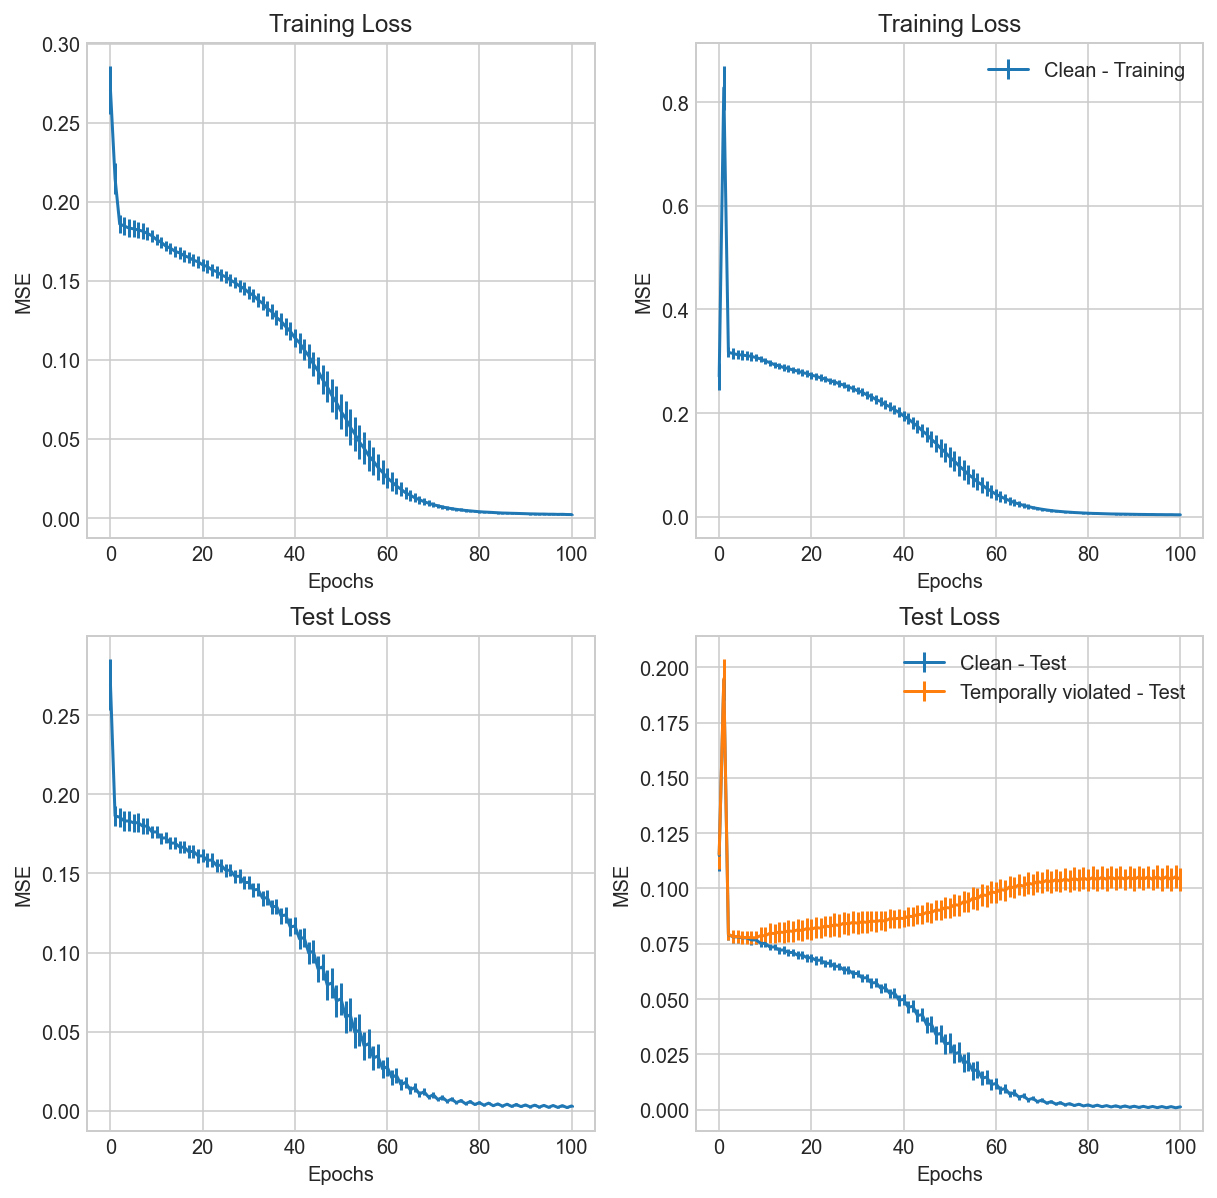

In [52]:
f = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.errorbar(np.arange(n_epochs+1),train_losses_mean,yerr=train_losses_std)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(2,2,2)
plt.errorbar(np.arange(n_epochs+1),train_expected_losses_mean,yerr=train_expected_losses_std,label='Clean - Training')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(2,2,3)
plt.errorbar(np.arange(n_epochs+1),test_losses_mean,yerr=test_losses_std)
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(2,2,4)
plt.errorbar(np.arange(n_epochs+1),test_expected_losses_mean,yerr=test_expected_losses_std,label='Clean - Test')
plt.errorbar(np.arange(n_epochs+1),test_surprise_losses_mean,yerr=test_surprise_losses_std,label='Temporally violated - Test')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

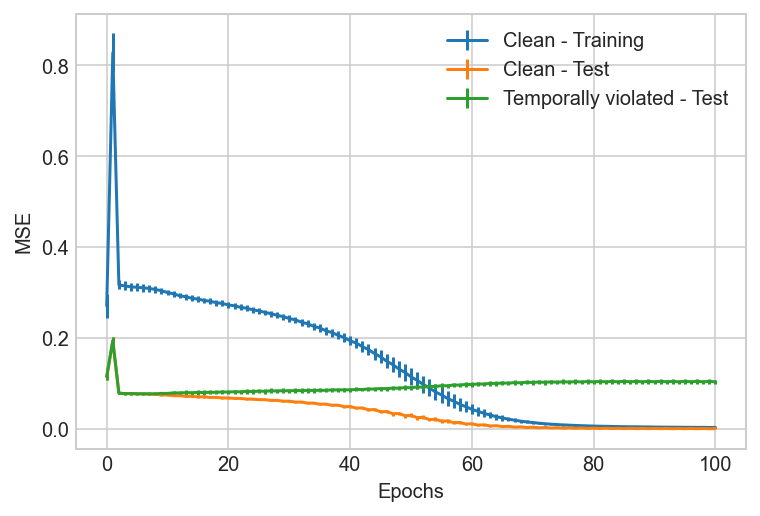

In [53]:
plt.errorbar(np.arange(n_epochs+1),train_expected_losses_mean,yerr=train_expected_losses_std,label='Clean - Training')
plt.errorbar(np.arange(n_epochs+1),test_expected_losses_mean,yerr=test_expected_losses_std,label='Clean - Test')
plt.errorbar(np.arange(n_epochs+1),test_surprise_losses_mean,yerr=test_surprise_losses_std,label='Temporally violated - Test')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

In [54]:
# kk=4
# a = np.unique(allStatesTest[kk][:,0])
# b = np.unique(allStatesTrain[kk][:,0])
# len(np.intersect1d(a,b))

### Representational Analyses

#### RNN Names

In [55]:
rnn_names = ['L4','L23','L56','H4','H23','H56']

In [56]:
# analyses_train_loader = {}

In [57]:
# for cntr in range(nRuns):
#     analyses_train_loader[cntr] = makeTensorLoaders((repsTrain[cntr],yRepsTrain[cntr],eTrain[cntr],surpTrain[cntr]),
#                                            batch_size,shuffle=False)

#### Pass data and store activations

In [58]:
def pass_data_store_activations(loader, nData, 
                                nRuns=nRuns, n_epochs=n_epochs, nSteps=nSteps, pop_list=pop_list, n_latent=n_latent,
                                batch_size = batch_size):
    
    model = {}
    
    activations_hidden_L23_np = {}
    activations_hidden_L4_np = {}
    activations_hidden_L56_np = {}

    activations_hidden_H23_np = {}
    activations_hidden_H4_np = {}
    activations_hidden_H56_np = {}

    activations_out_np = {}
    
    for cntr in range(nRuns):
        activations_hidden_L23_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,pop_list[1]*n_latent))
        activations_hidden_L4_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,pop_list[0]*n_latent))
        activations_hidden_L56_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,pop_list[2]*n_latent))

        activations_hidden_H23_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,pop_list[1]*n_latent))
        activations_hidden_H4_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,pop_list[0]*n_latent))
        activations_hidden_H56_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,pop_list[2]*n_latent))

        activations_out_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,dim))
        
        for e in tqdm(range(n_epochs+1)):

            cnt = 0

            ## Load model
            model[cntr] = microcircuit(n_features=dim,hidden_dim=n_latent,bsize=batch_size,manual_seed=seeds[cntr],task='lattice')
            model[cntr].to(device)
            model[cntr].load_state_dict(torch.load(pp_pts[cntr]+'predRNN_epoch_'+str(e)+'.pt'))
            model[cntr].eval()

            ## Pass clean samples
            for data, f_target, lastEvent, surpriseBinary in loader[cntr]:

                if train_on_gpu:
                    data, f_targetC = data.float().cuda(), f_target.float().cuda()
                else: data, f_targetC = data.float(), f_target.float()

                target = f_target

                output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[cntr](data)

                ## Collect activations  
                act_hidden_L23 = np.squeeze(RNN_outputs[0].detach().cpu().numpy())
                act_hidden_L4 = np.squeeze(RNN_outputs[1].detach().cpu().numpy())
                act_hidden_L56 = np.squeeze(RNN_outputs[2].detach().cpu().numpy())

                act_hidden_H23 = np.squeeze(RNN_outputs[3].detach().cpu().numpy())
                act_hidden_H4 = np.squeeze(RNN_outputs[4].detach().cpu().numpy())
                act_hidden_H56 = np.squeeze(RNN_outputs[5].detach().cpu().numpy())

                output_pred = np.squeeze(output_pred.detach().cpu().numpy())

                for i in range(batch_size):
                    if i < len(data):
                        label = target.data[i]

                        activations_hidden_L23_np[cntr][e,cnt] = act_hidden_L23[i]
                        activations_hidden_L4_np[cntr][e,cnt] = act_hidden_L4[i]
                        activations_hidden_L56_np[cntr][e,cnt] = act_hidden_L56[i]

                        activations_hidden_H23_np[cntr][e,cnt] = act_hidden_H23[i]
                        activations_hidden_H4_np[cntr][e,cnt] = act_hidden_H4[i]
                        activations_hidden_H56_np[cntr][e,cnt] = act_hidden_H56[i]

                        activations_out_np[cntr][e,cnt] = output_pred[i]

                        cnt += 1

    return (activations_hidden_L23_np,activations_hidden_L4_np,activations_hidden_L56_np,
            activations_hidden_H23_np,activations_hidden_H4_np,activations_hidden_H56_np), activations_out_np

In [59]:
# (L23_train,L4_train,L56_train,
#  H23_train,H4_train,H56_train,), out_train = pass_data_store_activations(analyses_train_loader, nTrain)

In [60]:
(L23_test,L4_test,L56_test,
 H23_test,H4_test,H56_test), out_test = pass_data_store_activations(test_loader, nTest)

100%|██████████| 101/101 [00:08<00:00, 11.65it/s]


In [61]:
(L23_temp,L4_temp,L56_temp,
 H23_temp,H4_temp,H56_temp), out_temp = pass_data_store_activations(test_temp_loader, nTest)

100%|██████████| 101/101 [00:08<00:00, 11.70it/s]


#### PCA for RNNs

In [62]:
def repsPCA(rnnActs):
    nEpochs, nSeqs, nRolls, nNeurons = rnnActs.shape
    pca_dict = {}
    nSamps = nSeqs*nRolls
    dimPCA = min(nNeurons,nSamps)
    repsR_transformed = np.zeros((nEpochs,nSamps,dimPCA))
    
    for ep in tqdm(range(nEpochs)):
        
        reps = rnnActs[ep]
        
        ## reshape
        repsR = np.zeros((nSeqs*nRolls,nNeurons))
        cnt = 0
        for ii in range(nSeqs):
            for jj in range(nRolls):
                repsR[cnt] = reps[ii,jj]
                cnt += 1
        ## PCA
        rnnPCA = PCA()
        repsR_transformed[ep] = rnnPCA.fit_transform(repsR)
        pca_dict[str(ep)] = rnnPCA
        
    return repsR_transformed, pca_dict

In [63]:
L23pca_train = {}
L4pca_train = {}
L56pca_train = {}

H23pca_train = {}
H4pca_train = {}
H56pca_train = {}

L23pca_test = {}
L4pca_test = {}
L56pca_test = {}

H23pca_test = {}
H4pca_test = {}
H56pca_test = {}

L23pca_temp = {}
L4pca_temp = {}
L56pca_temp = {}

H23pca_temp = {}
H4pca_temp = {}
H56pca_temp = {}

In [64]:
# for cntr in range(nRuns):
#     L23pca_train[cntr], _ = repsPCA(L23_train[cntr])
#     L4pca_train[cntr], _ = repsPCA(L4_train[cntr])
#     L56pca_train[cntr], _ = repsPCA(L56_train[cntr])

#     H23pca_train[cntr], _ = repsPCA(H23_train[cntr])
#     H4pca_train[cntr], _ = repsPCA(H4_train[cntr])
#     H56pca_train[cntr], _ = repsPCA(H56_train[cntr])

In [65]:
for cntr in range(nRuns):
    L23pca_test[cntr], _ = repsPCA(L23_test[cntr])
    L4pca_test[cntr], _ = repsPCA(L4_test[cntr])
    L56pca_test[cntr], _ = repsPCA(L56_test[cntr])

    H23pca_test[cntr], _ = repsPCA(H23_test[cntr])
    H4pca_test[cntr], _ = repsPCA(H4_test[cntr])
    H56pca_test[cntr], _ = repsPCA(H56_test[cntr])

100%|██████████| 101/101 [00:00<00:00, 157.13it/s]


In [66]:
for cntr in range(nRuns):
    L23pca_temp[cntr], _ = repsPCA(L23_temp[cntr])
    L4pca_temp[cntr], _ = repsPCA(L4_temp[cntr])
    L56pca_temp[cntr], _ = repsPCA(L56_temp[cntr])

    H23pca_temp[cntr], _ = repsPCA(H23_temp[cntr])
    H4pca_temp[cntr], _ = repsPCA(H4_temp[cntr])
    H56pca_temp[cntr], _ = repsPCA(H56_temp[cntr])

100%|██████████| 101/101 [00:00<00:00, 157.01it/s]


#### Labels, etc.

In [67]:
allStatesLabelsTrain = {}
allStatesLabelsTest = {}
allStatesLabelsTestTemp = {}

actionsLabelsTrain = {}
actionsLabelsTest = {}
actionsLabelsTestTemp = {}

In [68]:
def allStatesLabels(allStates,latLabs):
    nSamps, nSeqs, nDim = allStates.shape
    labels = np.zeros((nSamps,nSeqs),dtype=int)
    for ii in range(nSamps):
        for jj in range(nSeqs):
            labels[ii,jj] = np.where((latLabs[:,None] == allStates[ii,jj]).all(-1).any(-1)==1)[0][0]
    return labels

In [69]:
for cntr in range(nRuns):
#     allStatesLabelsTrain[cntr] = allStatesLabels(allStatesTrain[cntr],lattice_labels)
    allStatesLabelsTest[cntr] = allStatesLabels(allStatesTest[cntr],lattice_labels)
    allStatesLabelsTestTemp[cntr] = allStatesLabels(allStatesTestTemp[cntr],lattice_labels)
    
#     actionsLabelsTrain[cntr] = np.argmax(actionsTrain[cntr],-1)
    actionsLabelsTest[cntr] = np.argmax(actionsTest[cntr],-1)
    actionsLabelsTestTemp[cntr] = np.argmax(actionsTestTemp[cntr],-1)

In [70]:
# idxs0_train = np.array([6*x for x in range(nTrain)])
# idxs1_train = idxs0_train + 1
# idxs2_train = idxs0_train + 2
# idxs3_train = idxs0_train + 3
# idxs4_train = idxs0_train + 4
# idxs5_train = idxs0_train + 5

In [71]:
idxs0_test = np.array([6*x for x in range(nTest)])
idxs1_test = idxs0_test + 1
idxs2_test = idxs0_test + 2
idxs3_test = idxs0_test + 3
idxs4_test = idxs0_test + 4
idxs5_test = idxs0_test + 5

In [72]:
idxs_test_surp = np.sort(np.hstack((idxs4_test,idxs5_test)))

In [73]:
pos_test = np.tile(np.arange(nSteps),nTest).ravel()

#### Plots

#### Coloured by states

In [74]:
# cnt = 0
# ep = 50
# ix = idxs5_test
# seq = 3 ##0-3
# c = allStatesLabelsTest[cnt][:,seq] + 1
# s = 10#1*c
# colmap = 'copper'

# f = plt.figure(figsize=(16,10))

# plt.subplot(231)
# plt.scatter(L4pca_test[cnt][ep,ix,0],L4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L4')

# plt.subplot(232)
# plt.scatter(L23pca_test[cnt][ep,ix,0],L23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L2/3')

# plt.subplot(233)
# plt.scatter(L56pca_test[cnt][ep,ix,0],L56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L5/6')

# plt.subplot(234)
# plt.scatter(H4pca_test[cnt][ep,ix,0],H4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H4')

# plt.subplot(235)
# plt.scatter(H23pca_test[cnt][ep,ix,0],H23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H2/3')

# plt.subplot(236)
# plt.scatter(H56pca_test[cnt][ep,ix,0],H56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H5/6')

In [75]:
# cnt = 1
# ep = -1

# ix = idxs5_test
# seq = 3 ##0-3
# xy = 1 ##0/1

# c = allStatesTest[cnt][:,seq,xy] + 0.5
# s = 10#5*c
# colmap = 'copper'

# f = plt.figure(figsize=(16,10))

# plt.subplot(231)
# plt.scatter(L4pca_test[cnt][ep,ix,0],L4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L4')

# plt.subplot(232)
# plt.scatter(L23pca_test[cnt][ep,ix,0],L23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L2/3')

# plt.subplot(233)
# plt.scatter(L56pca_test[cnt][ep,ix,0],L56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L5/6')

# plt.subplot(234)
# plt.scatter(H4pca_test[cnt][ep,ix,0],H4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H4')

# plt.subplot(235)
# plt.scatter(H23pca_test[cnt][ep,ix,0],H23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H2/3')

# plt.subplot(236)
# plt.scatter(H56pca_test[cnt][ep,ix,0],H56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H5/6')

#### Coloured by distance from lattice centre

In [76]:
# cnt = 1
# ep = -1

# ix = idxs5_test
# seq = 3 ##0-3
# xy = 1 ##0/1

# c = norm(allStatesTest[cnt][:,seq],axis=-1)
# s = 10#5*c
# colmap = 'copper'

# f = plt.figure(figsize=(16,10))

# plt.subplot(231)
# plt.scatter(L4pca_test[cnt][ep,ix,0],L4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L4')

# plt.subplot(232)
# plt.scatter(L23pca_test[cnt][ep,ix,0],L23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L2/3')

# plt.subplot(233)
# plt.scatter(L56pca_test[cnt][ep,ix,0],L56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L5/6')

# plt.subplot(234)
# plt.scatter(H4pca_test[cnt][ep,ix,0],H4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H4')

# plt.subplot(235)
# plt.scatter(H23pca_test[cnt][ep,ix,0],H23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H2/3')

# plt.subplot(236)
# plt.scatter(H56pca_test[cnt][ep,ix,0],H56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H5/6')

In [77]:
# cnt = 1
# ep = -1

# ix = idxs5_test
# seq = 3 ##0-3
# xy = 1 ##0/1

# c = norm(allStatesTest[cnt][:,seq],axis=-1)
# s = 10#5*c
# colmap = 'copper'

# f = plt.figure(figsize=(16,10))

# plt.subplot(231)
# plt.scatter(L4pca_test[cnt][ep,ix,0],L4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L4')

# plt.subplot(232)
# plt.scatter(L23pca_test[cnt][ep,ix,0],L23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L2/3')

# plt.subplot(233)
# plt.scatter(L56pca_test[cnt][ep,ix,0],L56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L5/6')

# plt.subplot(234)
# plt.scatter(H4pca_test[cnt][ep,ix,0],H4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H4')

# plt.subplot(235)
# plt.scatter(H23pca_test[cnt][ep,ix,0],H23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H2/3')

# plt.subplot(236)
# plt.scatter(H56pca_test[cnt][ep,ix,0],H56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H5/6')

#### 3D plot

In [78]:
# cnt = 1
# ix = idxs0_test
# seq = 0

# c = norm(allStatesTest[cnt][:,seq],axis=-1)
# c = np.repeat(c,n_epochs+1,0)
# s = 10#5*c

# sub = 1
# colmap = 'copper'

# Zs = np.repeat(np.arange(n_epochs+1).reshape(-1,1),nTest,1)

In [79]:
# fig = plt.figure(figsize=(17,12))

# ax = fig.add_subplot(2, 3, 1, projection='3d')
# ax.scatter3D(L4pca_test[cnt][:,ix,0].ravel()[::sub],L4pca_test[cnt][:,ix,1].ravel()[::sub],
#              Zs.ravel()[::sub], c=c.ravel()[::sub], s=s, cmap=colmap);

# ax = fig.add_subplot(2, 3, 2, projection='3d')
# ax.scatter3D(L23pca_test[cnt][:,ix,0].ravel()[::sub],L23pca_test[cnt][:,ix,1].ravel()[::sub],
#              Zs.ravel()[::sub], c=c.ravel()[::sub], s=s, cmap=colmap);

# ax = fig.add_subplot(2, 3, 3, projection='3d')
# ax.scatter3D(L56pca_test[cnt][:,ix,0].ravel()[::sub],L56pca_test[cnt][:,ix,1].ravel()[::sub],
#              Zs.ravel()[::sub], c=c.ravel()[::sub], s=s, cmap=colmap);

# ax = fig.add_subplot(2, 3, 4, projection='3d')
# ax.scatter3D(H4pca_test[cnt][:,ix,0].ravel()[::sub],H4pca_test[cnt][:,ix,1].ravel()[::sub],
#              Zs.ravel()[::sub], c=c.ravel()[::sub], s=s, cmap=colmap);

# ax = fig.add_subplot(2, 3, 5, projection='3d')
# ax.scatter3D(H23pca_test[cnt][:,ix,0].ravel()[::sub],H23pca_test[cnt][:,ix,1].ravel()[::sub],
#              Zs.ravel()[::sub], c=c.ravel()[::sub], s=s, cmap=colmap);

# ax = fig.add_subplot(2, 3, 6, projection='3d')
# ax.scatter3D(H56pca_test[cnt][:,ix,0].ravel()[::sub],H56pca_test[cnt][:,ix,1].ravel()[::sub],
#              Zs.ravel()[::sub], c=c.ravel()[::sub], s=s, cmap=colmap);

# plt.show()

#### Coloured by actions

In [80]:
# cnt = 0
# ep = -1
# ix = idxs5_test
# seq = 3 ##0-3
# step = 5
# c = actionsLabelsTest[cnt][:,step] + 1
# s = 5*c
# colmap='Set1'

# f = plt.figure(figsize=(16,10))

# plt.subplot(231)
# plt.scatter(L4pca_test[cnt][ep,ix,0],L4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L4')

# plt.subplot(232)
# plt.scatter(L23pca_test[cnt][ep,ix,0],L23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L2/3')

# plt.subplot(233)
# plt.scatter(L56pca_test[cnt][ep,ix,0],L56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L5/6')

# plt.subplot(234)
# plt.scatter(H4pca_test[cnt][ep,ix,0],H4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H4')

# plt.subplot(235)
# plt.scatter(H23pca_test[cnt][ep,ix,0],H23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H2/3')

# plt.subplot(236)
# plt.scatter(H56pca_test[cnt][ep,ix,0],H56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H5/6')

In [81]:
# cnt = 0
# ep = -1
# ix = idxs5_test
# seq = 2 ##0-3
# step = 5
# c = (actionsLabelsTest[cnt][:,step]%2)*1. + 1
# s = 5*c
# colmap='Dark2'

# f = plt.figure(figsize=(16,10))

# plt.subplot(231)
# plt.scatter(L4pca_test[cnt][ep,ix,0],L4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L4')

# plt.subplot(232)
# plt.scatter(L23pca_test[cnt][ep,ix,0],L23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L2/3')

# plt.subplot(233)
# plt.scatter(L56pca_test[cnt][ep,ix,0],L56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L5/6')

# plt.subplot(234)
# plt.scatter(H4pca_test[cnt][ep,ix,0],H4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H4')

# plt.subplot(235)
# plt.scatter(H23pca_test[cnt][ep,ix,0],H23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H2/3')

# plt.subplot(236)
# plt.scatter(H56pca_test[cnt][ep,ix,0],H56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H5/6')

In [82]:
# cnt = 0
# ep = -1
# ix = idxs5_test
# seq = 2 ##0-3
# step = 5
# c = (actionsLabelsTest[cnt][:,step]>1)*1. + 1
# s = 5*c
# colmap='Dark2'

# f = plt.figure(figsize=(16,10))

# plt.subplot(231)
# plt.scatter(L4pca_test[cnt][ep,ix,0],L4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L4')

# plt.subplot(232)
# plt.scatter(L23pca_test[cnt][ep,ix,0],L23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L2/3')

# plt.subplot(233)
# plt.scatter(L56pca_test[cnt][ep,ix,0],L56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer L5/6')

# plt.subplot(234)
# plt.scatter(H4pca_test[cnt][ep,ix,0],H4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H4')

# plt.subplot(235)
# plt.scatter(H23pca_test[cnt][ep,ix,0],H23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H2/3')

# plt.subplot(236)
# plt.scatter(H56pca_test[cnt][ep,ix,0],H56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap=colmap)
# plt.title('Layer H5/6')

In [83]:
# cnt = 0
# ep = 50
# ix = idxs4_test
# seq = 2 ##0-3
# step = 3
# c = allStatesLabelsTest[cnt][:,seq]
# s = 1*c

# f = plt.figure(figsize=(16,10))

# plt.subplot(231)
# plt.scatter(L4pca_test[cnt][ep,ix,0],L4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap='Greens')
# plt.scatter(L4pca_temp[cnt][ep,ix,0],L4pca_temp[cnt][ep,ix,1],
#             c=c,s=s,cmap='Purples')
# plt.title('Layer L4')

# plt.subplot(232)
# plt.scatter(L23pca_test[cnt][ep,ix,0],L23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap='Greens')
# plt.scatter(L23pca_temp[cnt][ep,ix,0],L23pca_temp[cnt][ep,ix,1],
#             c=c,s=s,cmap='Purples')
# plt.title('Layer L2/3')

# plt.subplot(233)
# plt.scatter(L56pca_test[cnt][ep,ix,0],L56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap='Greens')
# plt.scatter(L56pca_temp[cnt][ep,ix,0],L56pca_temp[cnt][ep,ix,1],
#             c=c,s=s,cmap='Purples')
# plt.title('Layer L5/6')

# plt.subplot(234)
# plt.scatter(H4pca_test[cnt][ep,ix,0],H4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap='Greens')
# plt.scatter(H4pca_temp[cnt][ep,ix,0],H4pca_temp[cnt][ep,ix,1],
#             c=c,s=s,cmap='Purples')
# plt.title('Layer H4')

# plt.subplot(235)
# plt.scatter(H23pca_test[cnt][ep,ix,0],H23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap='Greens')
# plt.scatter(H23pca_temp[cnt][ep,ix,0],H23pca_temp[cnt][ep,ix,1],
#             c=c,s=s,cmap='Purples')
# plt.title('Layer H2/3')

# plt.subplot(236)
# plt.scatter(H56pca_test[cnt][ep,ix,0],H56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap='Greens')
# plt.scatter(H56pca_temp[cnt][ep,ix,0],H56pca_temp[cnt][ep,ix,1],
#             c=c,s=s,cmap='Purples')
# plt.title('Layer H5/6')

In [84]:
# cnt = 0
# ep = -1
# ix = idxs_surp
# seq = -1 ##0-3
# step = 4
# # c = actionsLabelsTest[cnt][:,step]
# # s = 5*c

# f = plt.figure(figsize=(16,10))

# plt.subplot(231)
# plt.scatter(L4pca_test[cnt][ep,ix,0],L4pca_test[cnt][ep,ix,1],
#             cmap='Greens')
# plt.scatter(L4pca_temp[cnt][ep,ix,0],L4pca_temp[cnt][ep,ix,1],
#             cmap='Purples')
# plt.title('Layer L4')

# plt.subplot(232)
# plt.scatter(L23pca_test[cnt][ep,ix,0],L23pca_test[cnt][ep,ix,1],
#             cmap='Greens')
# plt.scatter(L23pca_temp[cnt][ep,ix,0],L23pca_temp[cnt][ep,ix,1],
#             cmap='Purples')
# plt.title('Layer L2/3')

# plt.subplot(233)
# plt.scatter(L56pca_test[cnt][ep,ix,0],L56pca_test[cnt][ep,ix,1],
#             cmap='Greens')
# plt.scatter(L56pca_temp[cnt][ep,ix,0],L56pca_temp[cnt][ep,ix,1],
#             cmap='Purples')
# plt.title('Layer L5/6')

# plt.subplot(234)
# plt.scatter(H4pca_test[cnt][ep,ix,0],H4pca_test[cnt][ep,ix,1],
#             cmap='Greens')
# plt.scatter(H4pca_temp[cnt][ep,ix,0],H4pca_temp[cnt][ep,ix,1],
#             cmap='Purples')
# plt.title('Layer H4')

# plt.subplot(235)
# plt.scatter(H23pca_test[cnt][ep,ix,0],H23pca_test[cnt][ep,ix,1],
#             cmap='Greens')
# plt.scatter(H23pca_temp[cnt][ep,ix,0],H23pca_temp[cnt][ep,ix,1],
#             cmap='Purples')
# plt.title('Layer H2/3')

# plt.subplot(236)
# plt.scatter(H56pca_test[cnt][ep,ix,0],H56pca_test[cnt][ep,ix,1],
#             cmap='Greens')
# plt.scatter(H56pca_temp[cnt][ep,ix,0],H56pca_temp[cnt][ep,ix,1],
#             cmap='Purples')
# plt.title('Layer H5/6')

#### Supervised Decoding

#### Position

In [85]:
def repsDecodeSupervisedPosition(rnnActs,labels,clf='logistic'):
    nEpochs, nSamps, nNeurons = rnnActs.shape
    decode_dict = {}
    
    nClasses = 6
    
    reps_preds_probs = np.zeros((nEpochs,nSamps,nClasses))
    
    for ep in (range(nEpochs)):
        repsR = rnnActs[ep]
        
        ## Decoding
        if clf=='svm':
            clfR = SVC(kernel='linear',probability=True).fit(repsR,labels)
        elif clf=='logistic':
            clfR = LogisticRegression().fit(repsR,labels)
        elif clf=='perceptron':
            clfR = Perceptron().fit(repsR,labels)
        
        reps_preds_probs[ep] = clfR.predict_proba(repsR)
        decode_dict[str(ep)] = clfR
        
    return reps_preds_probs, decode_dict

In [86]:
testPCs = {}
tempPCs = {}

contextPCs_sub = {}

In [87]:
for cntr in range(nRuns):
    testPCs[cntr] = (L4pca_test[cntr],L23pca_test[cntr],L56pca_test[cntr],
                     H4pca_test[cntr],H23pca_test[cntr],H56pca_test[cntr])
    tempPCs[cntr] = (L4pca_temp[cntr],L23pca_temp[cntr],L56pca_temp[cntr],
                     H4pca_temp[cntr],H23pca_temp[cntr],H56pca_temp[cntr])
    
    for rnnNo in range(len(rnn_names)):
        contextPCs_sub[cntr,rnnNo] = np.hstack((testPCs[cntr][rnnNo][:,idxs_test_surp,:],
                                                tempPCs[cntr][rnnNo][:,idxs_test_surp,:]))

In [88]:
L4posPC = {}
L23posPC = {}
L56posPC = {}
H4posPC = {}
H23posPC = {}
H56posPC = {}

In [89]:
dims23 = np.array([1,2,4,8,16,32,64,80])
dims4 = np.array([1,2,4,8,16,32])
dims56 = np.array([1,2,4,8,16,32,64])

In [90]:
for cntr in tqdm(range(nRuns)):
    
    for d in dims23:
        L23posPC[cntr,d], _ = repsDecodeSupervisedPosition(testPCs[cntr][1][:,:,:d],pos_test)
        H23posPC[cntr,d], _ = repsDecodeSupervisedPosition(testPCs[cntr][4][:,:,:d],pos_test)
    
    for d in dims4:
        L4posPC[cntr,d], _ = repsDecodeSupervisedPosition(testPCs[cntr][0][:,:,:d],pos_test)
        H4posPC[cntr,d], _ = repsDecodeSupervisedPosition(testPCs[cntr][3][:,:,:d],pos_test)
        
    for d in dims56:
        L56posPC[cntr,d], _ = repsDecodeSupervisedPosition(testPCs[cntr][2][:,:,:d],pos_test)      
        H56posPC[cntr,d], _ = repsDecodeSupervisedPosition(testPCs[cntr][5][:,:,:d],pos_test)

100%|██████████| 5/5 [05:56<00:00, 71.39s/it]


In [91]:
preds_L23posPC = {}
preds_L4posPC = {}
preds_L56posPC = {}

preds_H23posPC = {}
preds_H4posPC = {}
preds_H56posPC = {}

In [92]:
accs_L23posPC = {}
accs_L4posPC = {}
accs_L56posPC = {}

accs_H23posPC = {}
accs_H4posPC = {}
accs_H56posPC = {}

In [93]:
for cntr in range(nRuns):
    
    for ep in range(n_epochs+1):
        
        for d in dims23:
            preds_L23posPC[cntr,d,ep] = np.argmax(L23posPC[cntr,d][ep],axis=-1)
            preds_H23posPC[cntr,d,ep] = np.argmax(H23posPC[cntr,d][ep],axis=-1)
            
            accs_L23posPC[cntr,d,ep] = accuracy_score(pos_test,preds_L23posPC[cntr,d,ep])
            accs_H23posPC[cntr,d,ep] = accuracy_score(pos_test,preds_H23posPC[cntr,d,ep])
            
        for d in dims4:
            preds_L4posPC[cntr,d,ep] = np.argmax(L4posPC[cntr,d][ep],axis=-1)
            preds_H4posPC[cntr,d,ep] = np.argmax(H4posPC[cntr,d][ep],axis=-1)
            
            accs_L4posPC[cntr,d,ep] = accuracy_score(pos_test,preds_L4posPC[cntr,d,ep])
            accs_H4posPC[cntr,d,ep] = accuracy_score(pos_test,preds_H4posPC[cntr,d,ep])
            
        for d in dims56:
            preds_L56posPC[cntr,d,ep] = np.argmax(L56posPC[cntr,d][ep],axis=-1)
            preds_H56posPC[cntr,d,ep] = np.argmax(H56posPC[cntr,d][ep],axis=-1)
            
            accs_L56posPC[cntr,d,ep] = accuracy_score(pos_test,preds_L56posPC[cntr,d,ep])
            accs_H56posPC[cntr,d,ep] = accuracy_score(pos_test,preds_H56posPC[cntr,d,ep])

In [94]:
tensor_accs_L23posPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_L4posPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_L56posPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_H23posPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_H4posPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_H56posPC = np.zeros((nRuns,len(dims56),n_epochs+1))

In [95]:
for ii in range(nRuns):
    
    for kk in range(n_epochs+1):
        
        for jj,d in enumerate(dims23):
            tensor_accs_L23posPC[ii,jj,kk] = accs_L23posPC[ii,d,kk]
            tensor_accs_H23posPC[ii,jj,kk] = accs_H23posPC[ii,d,kk]
            
        for jj,d in enumerate(dims4):
            tensor_accs_L4posPC[ii,jj,kk] = accs_L4posPC[ii,d,kk]
            tensor_accs_H4posPC[ii,jj,kk] = accs_H4posPC[ii,d,kk]
            
        for jj,d in enumerate(dims56):            
            tensor_accs_L56posPC[ii,jj,kk] = accs_L56posPC[ii,d,kk]            
            tensor_accs_H56posPC[ii,jj,kk] = accs_H56posPC[ii,d,kk]

In [96]:
mean_accs_L4posPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_L23posPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_L56posPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_H4posPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_H23posPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_H56posPC = np.zeros((len(dims56),n_epochs+1))

std_accs_L4posPC = np.zeros((len(dims4),n_epochs+1))
std_accs_L23posPC = np.zeros((len(dims23),n_epochs+1))
std_accs_L56posPC = np.zeros((len(dims56),n_epochs+1))

std_accs_H4posPC = np.zeros((len(dims4),n_epochs+1))
std_accs_H23posPC = np.zeros((len(dims23),n_epochs+1))
std_accs_H56posPC = np.zeros((len(dims56),n_epochs+1))

In [97]:
for ep in range(n_epochs+1):
    
    for dd, dim in enumerate(dims23):
        mean_accs_L23posPC[dd,ep] = np.mean(tensor_accs_L23posPC[:,dd,ep])
        mean_accs_H23posPC[dd,ep] = np.mean(tensor_accs_H23posPC[:,dd,ep])
        
        std_accs_L23posPC[dd,ep] = np.var(tensor_accs_L23posPC[:,dd,ep])
        std_accs_H23posPC[dd,ep] = np.var(tensor_accs_H23posPC[:,dd,ep])
        
    for dd, dim in enumerate(dims4):
        mean_accs_L4posPC[dd,ep] = np.mean(tensor_accs_L4posPC[:,dd,ep])
        mean_accs_H4posPC[dd,ep] = np.mean(tensor_accs_H4posPC[:,dd,ep])
        
        std_accs_L4posPC[dd,ep] = np.var(tensor_accs_L4posPC[:,dd,ep])
        std_accs_H4posPC[dd,ep] = np.var(tensor_accs_H4posPC[:,dd,ep])
        
    for dd, dim in enumerate(dims56):
        mean_accs_L56posPC[dd,ep] = np.mean(tensor_accs_L56posPC[:,dd,ep])
        mean_accs_H56posPC[dd,ep] = np.mean(tensor_accs_H56posPC[:,dd,ep])
        
        std_accs_L56posPC[dd,ep] = np.var(tensor_accs_L56posPC[:,dd,ep])
        std_accs_H56posPC[dd,ep] = np.var(tensor_accs_H56posPC[:,dd,ep])

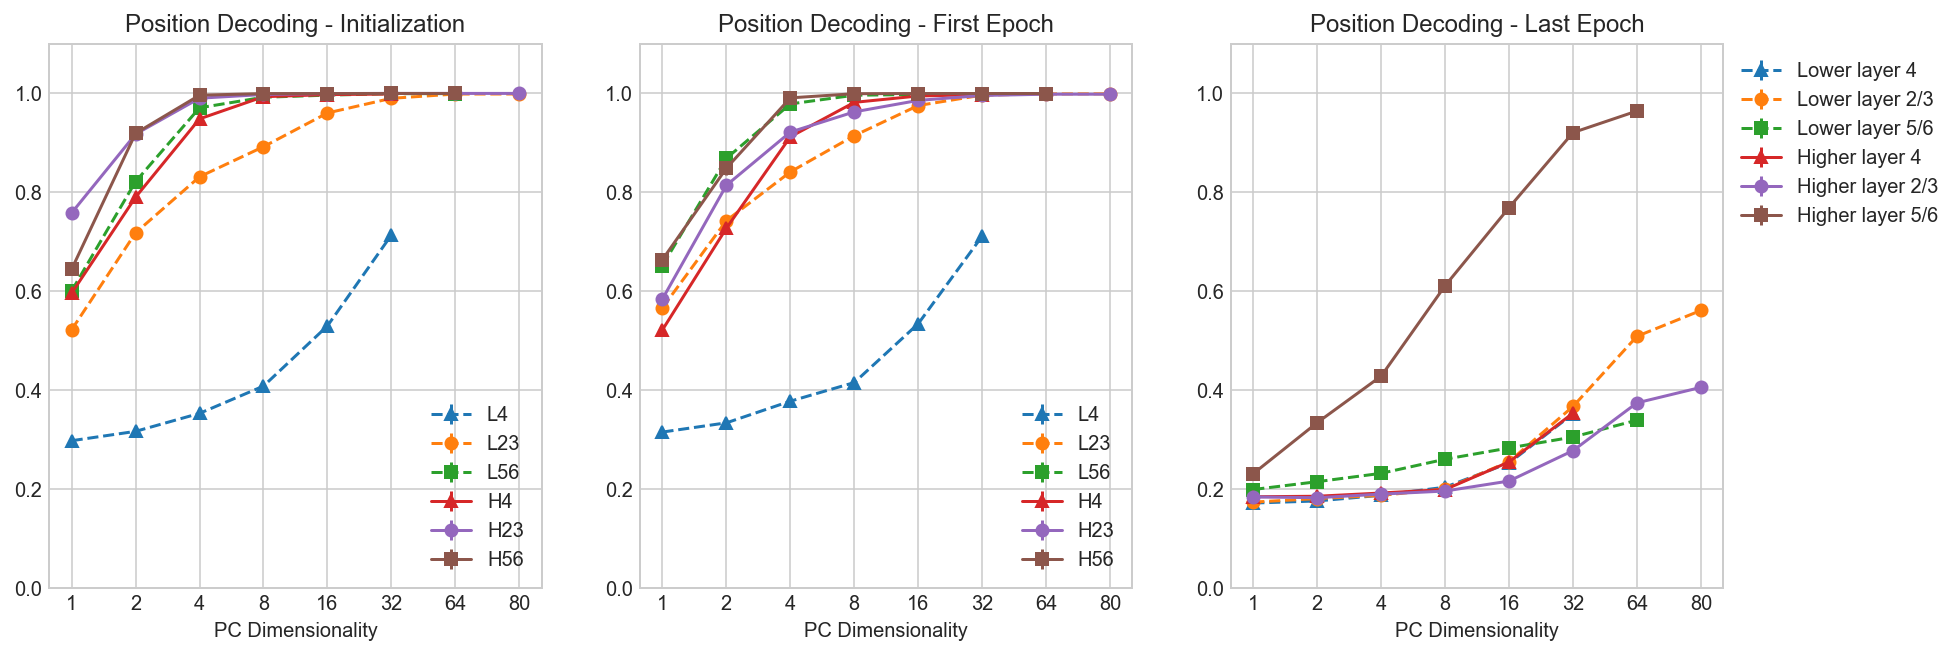

In [98]:
ffpos = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Position Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4posPC[:,0],yerr=std_accs_L4posPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23posPC[:,0],yerr=std_accs_L23posPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56posPC[:,0],yerr=std_accs_L56posPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4posPC[:,0],yerr=std_accs_H4posPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23posPC[:,0],yerr=std_accs_H23posPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56posPC[:,0],yerr=std_accs_H56posPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(132)
plt.title('Position Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4posPC[:,1],yerr=std_accs_L4posPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23posPC[:,1],yerr=std_accs_L23posPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56posPC[:,1],yerr=std_accs_L56posPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4posPC[:,1],yerr=std_accs_H4posPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23posPC[:,1],yerr=std_accs_H23posPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56posPC[:,1],yerr=std_accs_H56posPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(133)
plt.title('Position Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4posPC[:,-1],yerr=std_accs_L4posPC[:,-1],label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23posPC[:,-1],yerr=std_accs_L23posPC[:,-1],label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56posPC[:,-1],yerr=std_accs_L56posPC[:,-1],label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4posPC[:,-1],yerr=std_accs_H4posPC[:,-1],label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23posPC[:,-1],yerr=std_accs_H23posPC[:,-1],label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56posPC[:,-1],yerr=std_accs_H56posPC[:,-1],label='Higher layer 5/6',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1,1))

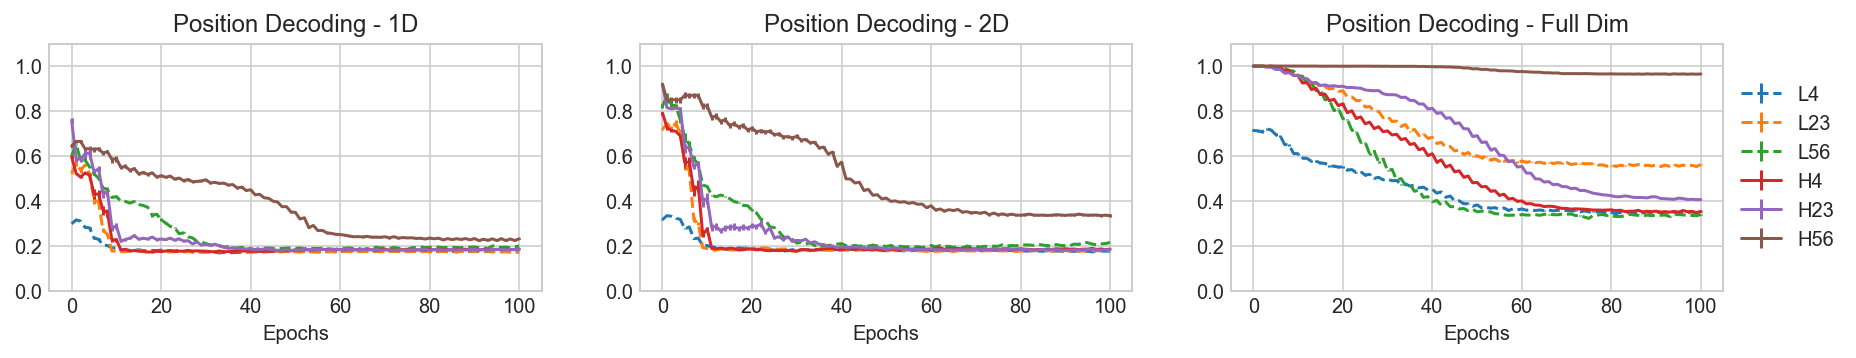

In [99]:
ffpos_epoch = plt.figure(figsize=(15,5))

plt.subplot(231)
plt.title('Position Decoding - 1D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4posPC[0],yerr=std_accs_L4posPC[0],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23posPC[0],yerr=std_accs_L23posPC[0],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56posPC[0],yerr=std_accs_L56posPC[0],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4posPC[0],yerr=std_accs_H4posPC[0],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23posPC[0],yerr=std_accs_H23posPC[0],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56posPC[0],yerr=std_accs_H56posPC[0],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(232)
plt.title('Position Decoding - 2D')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4posPC[1],yerr=std_accs_L4posPC[1],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23posPC[1],yerr=std_accs_L23posPC[1],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56posPC[1],yerr=std_accs_L56posPC[1],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4posPC[1],yerr=std_accs_H4posPC[1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23posPC[1],yerr=std_accs_H23posPC[1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56posPC[1],yerr=std_accs_H56posPC[1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.subplot(233)
plt.title('Position Decoding - Full Dim')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L4posPC[-1],yerr=std_accs_L4posPC[-1],label='L4',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L23posPC[-1],yerr=std_accs_L23posPC[-1],label='L23',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_L56posPC[-1],yerr=std_accs_L56posPC[-1],label='L56',fmt='--')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H4posPC[-1],yerr=std_accs_H4posPC[-1],label='H4',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H23posPC[-1],yerr=std_accs_H23posPC[-1],label='H23',fmt='-')
plt.errorbar(np.arange(n_epochs+1),mean_accs_H56posPC[-1],yerr=std_accs_H56posPC[-1],label='H56',fmt='-')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
# plt.legend()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Text(0, 0.5, 'Accuracy')

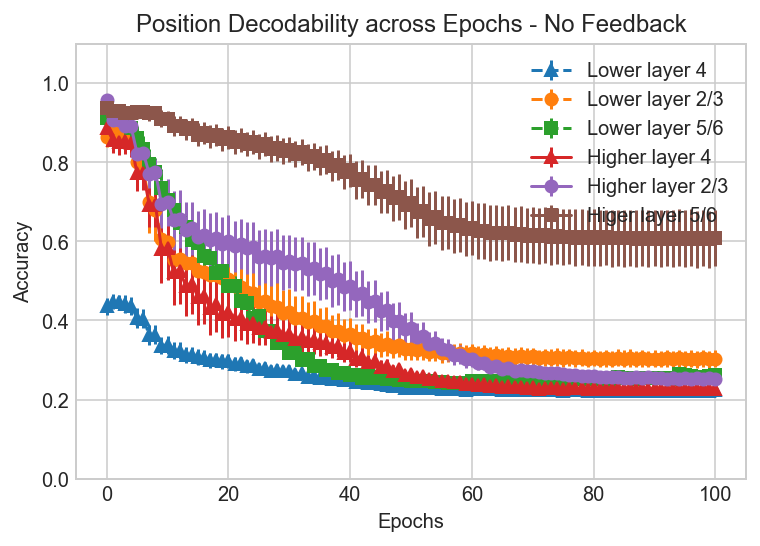

In [100]:
fpos_pcs = plt.figure()
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L4posPC,0),yerr=np.var(mean_accs_L4posPC,0),label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L23posPC,0),yerr=np.var(mean_accs_L23posPC,0),label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L56posPC,0),yerr=np.var(mean_accs_L56posPC,0),label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H4posPC,0),yerr=np.var(mean_accs_H4posPC,0),label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H23posPC,0),yerr=np.var(mean_accs_H23posPC,0),label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H56posPC,0),yerr=np.var(mean_accs_H56posPC,0),label='Higer layer 5/6',fmt='-s')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Position Decodability across Epochs - No Feedback')
plt.ylabel('Accuracy')

#### Image ID and Surprise (only surprise position)

In [101]:
context_sub_surp = np.array([0]*2*nTest + [1]*2*nTest)

In [102]:
context_sub_imgIDs = {}
for cntr in range(nRuns):
    context_sub_imgIDs[cntr] = np.hstack((np.repeat(allStatesLabelsTest[cntr][:,2],nRepeats),
                                          np.repeat(allStatesLabelsTestTemp[cntr][:,2],nRepeats)))

In [103]:
L23imgPC = {}
L4imgPC = {}
L56imgPC = {}

H23imgPC = {}
H4imgPC = {}
H56imgPC = {}

L23surpPC = {}
L4surpPC = {}
L56surpPC = {}

H23surpPC = {}
H4surpPC = {}
H56surpPC = {}

In [104]:
def repsDecodeSupervisedContext(rnnActs,labels,decodeType='surprise',clf='logistic'):
    nEpochs, nSamps, nNeurons = rnnActs.shape
    decode_dict = {}
    
    if decodeType == 'surprise':
        nClasses = 2
    elif decodeType == 'imageID':
        nClasses = nStates
    
    reps_preds_probs = np.zeros((nEpochs,nSamps,nClasses))
    
    for ep in (range(nEpochs)):
        repsR = rnnActs[ep]
        
        ## Decoding
        if clf=='svm':
            clfR = SVC(kernel='linear',probability=True).fit(repsR,labels)
        elif clf=='logistic':
            clfR = LogisticRegression().fit(repsR,labels)
        elif clf=='perceptron':
            clfR = Perceptron().fit(repsR,labels)
        
        reps_preds_probs[ep] = clfR.predict_proba(repsR)
        decode_dict[str(ep)] = clfR
        
    return reps_preds_probs, decode_dict

In [105]:
for cntr in tqdm(range(nRuns)):
    for d in dims23:
        L23imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,1][:,:,:d],context_sub_imgIDs[cntr],decodeType='imageID')
        H23imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,4][:,:,:d],context_sub_imgIDs[cntr],decodeType='imageID')
        
        L23surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,1][:,:,:d],context_sub_surp,decodeType='surprise')
        H23surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,4][:,:,:d],context_sub_surp,decodeType='surprise')
        
    for d in dims4:
        L4imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,0][:,:,:d],context_sub_imgIDs[cntr],decodeType='imageID')
        H4imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,3][:,:,:d],context_sub_imgIDs[cntr],decodeType='imageID')
        
        L4surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,0][:,:,:d],context_sub_surp,decodeType='surprise')
        H4surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,3][:,:,:d],context_sub_surp,decodeType='surprise')
    for d in dims56:

        ## Context Sub, ImageID
        L56imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,2][:,:,:d],context_sub_imgIDs[cntr],decodeType='imageID')
        H56imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,5][:,:,:d],context_sub_imgIDs[cntr],decodeType='imageID')

        ## Context Sub, Surprise
        L56surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,2][:,:,:d],context_sub_surp,decodeType='surprise')
        H56surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,5][:,:,:d],context_sub_surp,decodeType='surprise')

100%|██████████| 5/5 [14:51<00:00, 178.27s/it]


In [106]:
preds_L23imgPC = {}
preds_L4imgPC = {}
preds_L56imgPC = {}

preds_H23imgPC = {}
preds_H4imgPC = {}
preds_H56imgPC = {}

preds_L23surpPC = {}
preds_L4surpPC = {}
preds_L56surpPC = {}

preds_H23surpPC = {}
preds_H4surpPC = {}
preds_H56surpPC = {}

In [107]:
accs_L23imgPC = {}
accs_L4imgPC = {}
accs_L56imgPC = {}

accs_H23imgPC = {}
accs_H4imgPC = {}
accs_H56imgPC = {}

accs_L23surpPC = {}
accs_L4surpPC = {}
accs_L56surpPC = {}

accs_H23surpPC = {}
accs_H4surpPC = {}
accs_H56surpPC = {}

In [108]:
for cntr in range(nRuns):
    for ep in range(n_epochs+1):
        
        for d in dims23:
            preds_L23imgPC[cntr,d,ep] = np.argmax(L23imgPC[cntr,d][ep],axis=-1)
            preds_H23imgPC[cntr,d,ep] = np.argmax(H23imgPC[cntr,d][ep],axis=-1)
            
            preds_L23surpPC[cntr,d,ep] = np.argmax(L23surpPC[cntr,d][ep],axis=-1)
            preds_H23surpPC[cntr,d,ep] = np.argmax(H23surpPC[cntr,d][ep],axis=-1)
            
            accs_L23imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs[cntr],preds_L23imgPC[cntr,d,ep])
            accs_H23imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs[cntr],preds_H23imgPC[cntr,d,ep])
            
            accs_L23surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_L23surpPC[cntr,d,ep])
            accs_H23surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_H23surpPC[cntr,d,ep])
            
        for d in dims4:
            preds_L4imgPC[cntr,d,ep] = np.argmax(L4imgPC[cntr,d][ep],axis=-1)
            preds_H4imgPC[cntr,d,ep] = np.argmax(H4imgPC[cntr,d][ep],axis=-1)
            
            preds_L4surpPC[cntr,d,ep] = np.argmax(L4surpPC[cntr,d][ep],axis=-1)
            preds_H4surpPC[cntr,d,ep] = np.argmax(H4surpPC[cntr,d][ep],axis=-1)
            
            accs_L4imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs[cntr],preds_L4imgPC[cntr,d,ep])
            accs_H4imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs[cntr],preds_H4imgPC[cntr,d,ep])
            
            accs_L4surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_L4surpPC[cntr,d,ep])
            accs_H4surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_H4surpPC[cntr,d,ep])
                
        for d in dims56:        
            preds_L56imgPC[cntr,d,ep] = np.argmax(L56imgPC[cntr,d][ep],axis=-1)
            preds_H56imgPC[cntr,d,ep] = np.argmax(H56imgPC[cntr,d][ep],axis=-1)
            
            preds_L56surpPC[cntr,d,ep] = np.argmax(L56surpPC[cntr,d][ep],axis=-1)
            preds_H56surpPC[cntr,d,ep] = np.argmax(H56surpPC[cntr,d][ep],axis=-1)
            
            accs_L56imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs[cntr],preds_L56imgPC[cntr,d,ep])
            accs_H56imgPC[cntr,d,ep] = accuracy_score(context_sub_imgIDs[cntr],preds_H56imgPC[cntr,d,ep])
            
            accs_L56surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_L56surpPC[cntr,d,ep])
            accs_H56surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_H56surpPC[cntr,d,ep])

In [109]:
tensor_accs_L23imgPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_L4imgPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_L56imgPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_H23imgPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_H4imgPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_H56imgPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_L23surpPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_L4surpPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_L56surpPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_H23surpPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_H4surpPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_H56surpPC = np.zeros((nRuns,len(dims56),n_epochs+1))

In [110]:
for ii in range(nRuns):
    for kk in range(n_epochs+1):
        
        for jj,d in enumerate(dims23):
            tensor_accs_L23imgPC[ii,jj,kk] = accs_L23imgPC[ii,d,kk]
            tensor_accs_H23imgPC[ii,jj,kk] = accs_H23imgPC[ii,d,kk]
            
            tensor_accs_L23surpPC[ii,jj,kk] = accs_L23surpPC[ii,d,kk]
            tensor_accs_H23surpPC[ii,jj,kk] = accs_H23surpPC[ii,d,kk]
            
        
        for jj,d in enumerate(dims4):
            tensor_accs_L4imgPC[ii,jj,kk] = accs_L4imgPC[ii,d,kk]
            tensor_accs_H4imgPC[ii,jj,kk] = accs_H4imgPC[ii,d,kk]
            
            tensor_accs_L4surpPC[ii,jj,kk] = accs_L4surpPC[ii,d,kk]
            tensor_accs_H4surpPC[ii,jj,kk] = accs_H4surpPC[ii,d,kk]
            
        for jj,d in enumerate(dims56):            
            tensor_accs_L56imgPC[ii,jj,kk] = accs_L56imgPC[ii,d,kk]
            tensor_accs_H56imgPC[ii,jj,kk] = accs_H56imgPC[ii,d,kk]

            tensor_accs_L56surpPC[ii,jj,kk] = accs_L56surpPC[ii,d,kk]
            tensor_accs_H56surpPC[ii,jj,kk] = accs_H56surpPC[ii,d,kk]

In [111]:
mean_accs_L4imgPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_L23imgPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_L56imgPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_H4imgPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_H23imgPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_H56imgPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_L4surpPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_L23surpPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_L56surpPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_H4surpPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_H23surpPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_H56surpPC = np.zeros((len(dims56),n_epochs+1))

std_accs_L4imgPC = np.zeros((len(dims4),n_epochs+1))
std_accs_L23imgPC = np.zeros((len(dims23),n_epochs+1))
std_accs_L56imgPC = np.zeros((len(dims56),n_epochs+1))

std_accs_H4imgPC = np.zeros((len(dims4),n_epochs+1))
std_accs_H23imgPC = np.zeros((len(dims23),n_epochs+1))
std_accs_H56imgPC = np.zeros((len(dims56),n_epochs+1))

std_accs_L4surpPC = np.zeros((len(dims4),n_epochs+1))
std_accs_L23surpPC = np.zeros((len(dims23),n_epochs+1))
std_accs_L56surpPC = np.zeros((len(dims56),n_epochs+1))

std_accs_H4surpPC = np.zeros((len(dims4),n_epochs+1))
std_accs_H23surpPC = np.zeros((len(dims23),n_epochs+1))
std_accs_H56surpPC = np.zeros((len(dims56),n_epochs+1))

In [112]:
for ep in range(n_epochs+1):
    
    for dd, dims in enumerate(dims23):
        mean_accs_L23imgPC[dd,ep] = np.mean(tensor_accs_L23imgPC[:,dd,ep])
        mean_accs_H23imgPC[dd,ep] = np.mean(tensor_accs_H23imgPC[:,dd,ep])
        
        std_accs_L23imgPC[dd,ep] = np.var(tensor_accs_L23imgPC[:,dd,ep])
        std_accs_H23imgPC[dd,ep] = np.var(tensor_accs_H23imgPC[:,dd,ep])
        
        mean_accs_L23surpPC[dd,ep] = np.mean(tensor_accs_L23surpPC[:,dd,ep])
        mean_accs_H23surpPC[dd,ep] = np.mean(tensor_accs_H23surpPC[:,dd,ep])
        
        std_accs_L23surpPC[dd,ep] = np.var(tensor_accs_L23surpPC[:,dd,ep])
        std_accs_H23surpPC[dd,ep] = np.var(tensor_accs_H23surpPC[:,dd,ep])
        
    for dd, dims in enumerate(dims4):
        mean_accs_L4imgPC[dd,ep] = np.mean(tensor_accs_L4imgPC[:,dd,ep])
        mean_accs_H4imgPC[dd,ep] = np.mean(tensor_accs_H4imgPC[:,dd,ep])
        
        std_accs_L4imgPC[dd,ep] = np.var(tensor_accs_L4imgPC[:,dd,ep])
        std_accs_H4imgPC[dd,ep] = np.var(tensor_accs_H4imgPC[:,dd,ep])
        
        mean_accs_L4surpPC[dd,ep] = np.mean(tensor_accs_L4surpPC[:,dd,ep])
        mean_accs_H4surpPC[dd,ep] = np.mean(tensor_accs_H4surpPC[:,dd,ep])
        
        std_accs_L4surpPC[dd,ep] = np.var(tensor_accs_L4surpPC[:,dd,ep])
        std_accs_H4surpPC[dd,ep] = np.var(tensor_accs_H4surpPC[:,dd,ep])
        
    for dd, dims in enumerate(dims56):
        mean_accs_L56imgPC[dd,ep] = np.mean(tensor_accs_L56imgPC[:,dd,ep])        
        mean_accs_H56imgPC[dd,ep] = np.mean(tensor_accs_H56imgPC[:,dd,ep])
        
        std_accs_L56imgPC[dd,ep] = np.var(tensor_accs_L56imgPC[:,dd,ep])
        std_accs_H56imgPC[dd,ep] = np.var(tensor_accs_H56imgPC[:,dd,ep])
        
        mean_accs_L56surpPC[dd,ep] = np.mean(tensor_accs_L56surpPC[:,dd,ep])
        mean_accs_H56surpPC[dd,ep] = np.mean(tensor_accs_H56surpPC[:,dd,ep])
        
        std_accs_L56surpPC[dd,ep] = np.var(tensor_accs_L56surpPC[:,dd,ep])        
        std_accs_H56surpPC[dd,ep] = np.var(tensor_accs_H56surpPC[:,dd,ep])

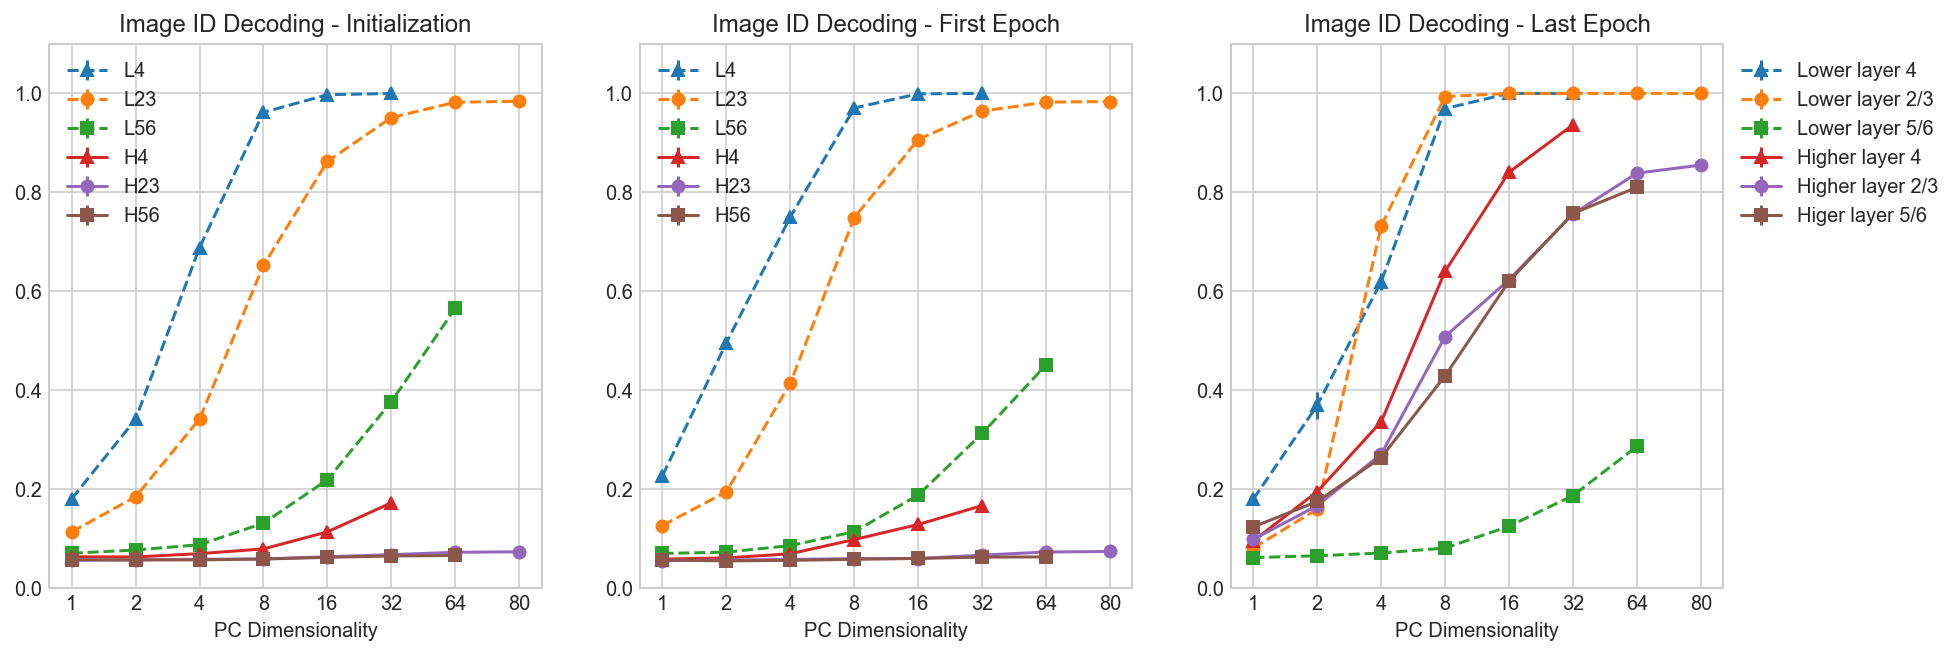

In [113]:
ffdim = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Image ID Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4imgPC[:,0],yerr=std_accs_L4imgPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23imgPC[:,0],yerr=std_accs_L23imgPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56imgPC[:,0],yerr=std_accs_L56imgPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4imgPC[:,0],yerr=std_accs_H4imgPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23imgPC[:,0],yerr=std_accs_H23imgPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56imgPC[:,0],yerr=std_accs_H56imgPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(132)
plt.title('Image ID Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4imgPC[:,1],yerr=std_accs_L4imgPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23imgPC[:,1],yerr=std_accs_L23imgPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56imgPC[:,1],yerr=std_accs_L56imgPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4imgPC[:,1],yerr=std_accs_H4imgPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23imgPC[:,1],yerr=std_accs_H23imgPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56imgPC[:,1],yerr=std_accs_H56imgPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(133)
plt.title('Image ID Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4imgPC[:,-1],yerr=std_accs_L4imgPC[:,-1],label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23imgPC[:,-1],yerr=std_accs_L23imgPC[:,-1],label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56imgPC[:,-1],yerr=std_accs_L56imgPC[:,-1],label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4imgPC[:,-1],yerr=std_accs_H4imgPC[:,-1],label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23imgPC[:,-1],yerr=std_accs_H23imgPC[:,-1],label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56imgPC[:,-1],yerr=std_accs_H56imgPC[:,-1],label='Higer layer 5/6',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1,1))

Text(0, 0.5, 'Accuracy')

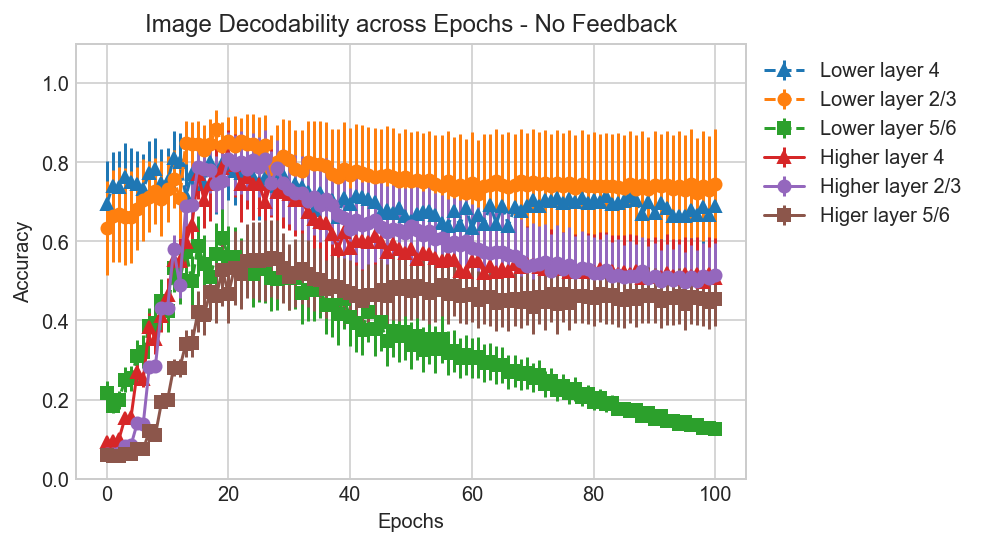

In [114]:
fimg_pcs = plt.figure()
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L4imgPC,0),yerr=np.var(mean_accs_L4imgPC,0),label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L23imgPC,0),yerr=np.var(mean_accs_L23imgPC,0),label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L56imgPC,0),yerr=np.var(mean_accs_L56imgPC,0),label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H4imgPC,0),yerr=np.var(mean_accs_H4imgPC,0),label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H23imgPC,0),yerr=np.var(mean_accs_H23imgPC,0),label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H56imgPC,0),yerr=np.var(mean_accs_H56imgPC,0),label='Higer layer 5/6',fmt='-s')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Image Decodability across Epochs - No Feedback')
plt.ylabel('Accuracy')

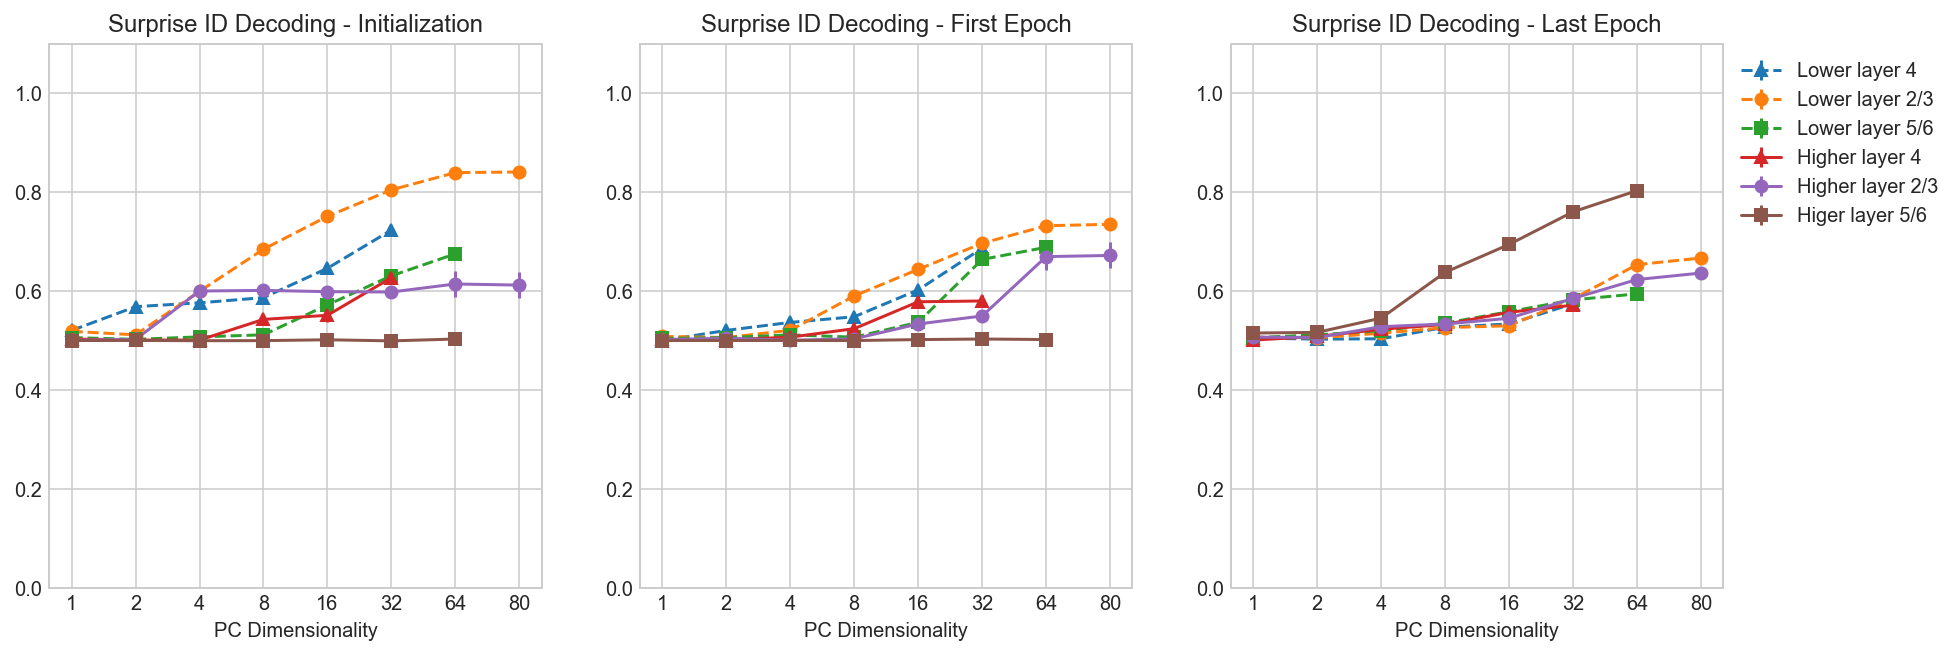

In [115]:
ffsurp_dim = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Surprise ID Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,0],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,0],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,0],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,0],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,0],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,0],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
# plt.legend()

plt.subplot(132)
plt.title('Surprise ID Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,1],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,1],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,1],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,1],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,1],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,1],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
# plt.legend()

plt.subplot(133)
plt.title('Surprise ID Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,-1],yerr=std_accs_L4surpPC[:,-1],label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,-1],yerr=std_accs_L23surpPC[:,-1],label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,-1],yerr=std_accs_L56surpPC[:,-1],label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,-1],yerr=std_accs_H4surpPC[:,-1],label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,-1],yerr=std_accs_H23surpPC[:,-1],label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,-1],yerr=std_accs_H56surpPC[:,-1],label='Higer layer 5/6',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1,1))

Text(0, 0.5, 'Accuracy')

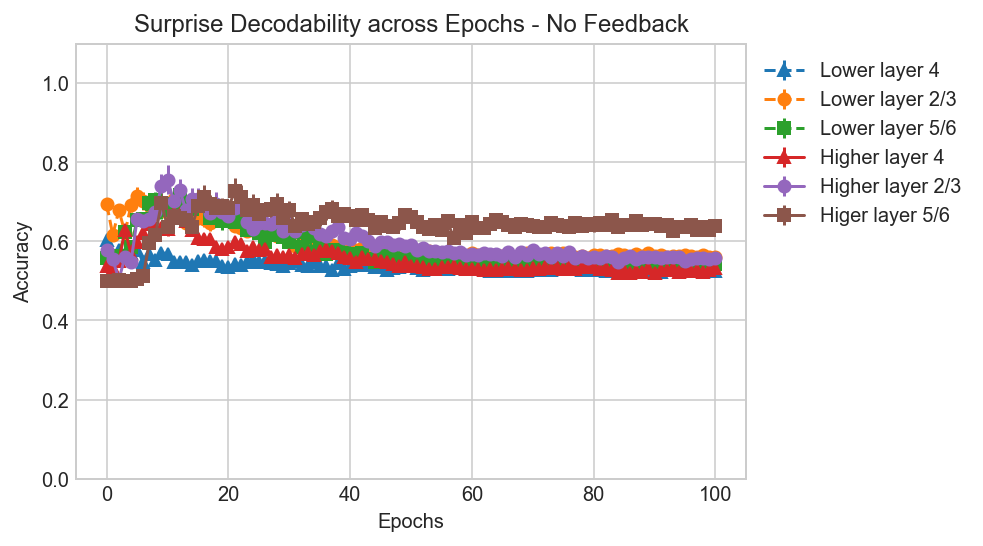

In [116]:
fsurp_pcs = plt.figure()
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L4surpPC,0),yerr=np.var(mean_accs_L4surpPC,0),label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L23surpPC,0),yerr=np.var(mean_accs_L23surpPC,0),label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L56surpPC,0),yerr=np.var(mean_accs_L56surpPC,0),label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H4surpPC,0),yerr=np.var(mean_accs_H4surpPC,0),label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H23surpPC,0),yerr=np.var(mean_accs_H23surpPC,0),label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H56surpPC,0),yerr=np.var(mean_accs_H56surpPC,0),label='Higer layer 5/6',fmt='-s')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Surprise Decodability across Epochs - No Feedback')
plt.ylabel('Accuracy')

In [117]:
np.save(pp+'preds_img_temp_L4-no-fb-lattice',preds_L4imgPC)
np.save(pp+'preds_img_temp_L23-no-fb-lattice',preds_L23imgPC)
np.save(pp+'preds_img_temp_L56-no-fb-lattice',preds_L56imgPC)
np.save(pp+'preds_img_temp_H4-no-fb-lattice',preds_H4imgPC)
np.save(pp+'preds_img_temp_H23-no-fb-lattice',preds_H23imgPC)
np.save(pp+'preds_img_temp_H56-no-fb-lattice',preds_H56imgPC)

np.save(pp+'accs_img_temp_L4-no-fb-lattice',accs_L4imgPC)
np.save(pp+'accs_img_temp_L23-no-fb-lattice',accs_L23imgPC)
np.save(pp+'accs_img_temp_L56-no-fb-lattice',accs_L56imgPC)
np.save(pp+'accs_img_temp_H4-no-fb-lattice',accs_H4imgPC)
np.save(pp+'accs_img_temp_H23-no-fb-lattice',accs_H23imgPC)
np.save(pp+'accs_img_temp_H56-no-fb-lattice',accs_H56imgPC)

In [118]:
np.save(pp+'preds_pos_temp_L4-no-fb-lattice',preds_L4posPC)
np.save(pp+'preds_pos_temp_L23-no-fb-lattice',preds_L23posPC)
np.save(pp+'preds_pos_temp_L56-no-fb-lattice',preds_L56posPC)
np.save(pp+'preds_pos_temp_H4-no-fb-lattice',preds_H4posPC)
np.save(pp+'preds_pos_temp_H23-no-fb-lattice',preds_H23posPC)
np.save(pp+'preds_pos_temp_H56-no-fb-lattice',preds_H56posPC)

np.save(pp+'accs_pos_temp_L4-no-fb-lattice',accs_L4posPC)
np.save(pp+'accs_pos_temp_L23-no-fb-lattice',accs_L23posPC)
np.save(pp+'accs_pos_temp_L56-no-fb-lattice',accs_L56posPC)
np.save(pp+'accs_pos_temp_H4-no-fb-lattice',accs_H4posPC)
np.save(pp+'accs_pos_temp_H23-no-fb-lattice',accs_H23posPC)
np.save(pp+'accs_pos_temp_H56-no-fb-lattice',accs_H56posPC)

In [119]:
np.save(pp+'preds_surp_temp_L4-no-fb-lattice',preds_L4surpPC)
np.save(pp+'preds_surp_temp_L23-no-fb-lattice',preds_L23surpPC)
np.save(pp+'preds_surp_temp_L56-no-fb-lattice',preds_L56surpPC)
np.save(pp+'preds_surp_temp_H4-no-fb-lattice',preds_H4surpPC)
np.save(pp+'preds_surp_temp_H23-no-fb-lattice',preds_H23surpPC)
np.save(pp+'preds_surp_temp_H56-no-fb-lattice',preds_H56surpPC)

np.save(pp+'accs_surp_temp_L4-no-fb-lattice',accs_L4surpPC)
np.save(pp+'accs_surp_temp_L23-no-fb-lattice',accs_L23surpPC)
np.save(pp+'accs_surp_temp_L56-no-fb-lattice',accs_L56surpPC)
np.save(pp+'accs_surp_temp_H4-no-fb-lattice',accs_H4surpPC)
np.save(pp+'accs_surp_temp_H23-no-fb-lattice',accs_H23surpPC)
np.save(pp+'accs_surp_temp_H56-no-fb-lattice',accs_H56surpPC)

#### Latent variable decoding

In [120]:
def repsDecodeSupervisedLatents(rnnActs,labels,decodeType='action',clf='logistic'):
    nEpochs, nSamps, nNeurons = rnnActs.shape
    decode_dict = {}
    
    if decodeType == 'action':
        nClasses = 4
    else:
        nClasses = 5
        
    reps_preds_probs = np.zeros((nEpochs,nSamps,nClasses))
    
    for ep in (range(nEpochs)):
        repsR = rnnActs[ep]
        
        ## Decoding
        if clf=='svm':
            clfR = SVC(kernel='linear',probability=True).fit(repsR,labels)
        elif clf=='logistic':
            clfR = LogisticRegression().fit(repsR,labels)
        elif clf=='perceptron':
            clfR = Perceptron().fit(repsR,labels)
        
        reps_preds_probs[ep] = clfR.predict_proba(repsR)
        decode_dict[str(ep)] = clfR
        
    return reps_preds_probs, decode_dict

In [121]:
L23actPC = {}
L4actPC = {}
L56actPC = {}

H23actPC = {}
H4actPC = {}
H56actPC = {}

L23distPC = {}
L4distPC = {}
L56distPC = {}

H23distPC = {}
H4distPC = {}
H56distPC = {}

In [122]:
for cntr in tqdm(range(nRuns)):
    
    for d in dims23:
        L23actPC[cntr,d], _ = repsDecodeSupervisedLatents(testPCs[cntr][1][:,:,:d],actionsLabelsTest[cnt].ravel())
        H23actPC[cntr,d], _ = repsDecodeSupervisedLatents(testPCs[cntr][4][:,:,:d],actionsLabelsTest[cnt].ravel())
    
    for d in dims4:
        L4actPC[cntr,d], _ = repsDecodeSupervisedLatents(testPCs[cntr][0][:,:,:d],actionsLabelsTest[cnt].ravel())
        H4actPC[cntr,d], _ = repsDecodeSupervisedLatents(testPCs[cntr][3][:,:,:d],actionsLabelsTest[cnt].ravel())
        
    for d in dims56:
        L56actPC[cntr,d], _ = repsDecodeSupervisedLatents(testPCs[cntr][2][:,:,:d],actionsLabelsTest[cnt].ravel())      
        H56actPC[cntr,d], _ = repsDecodeSupervisedLatents(testPCs[cntr][5][:,:,:d],actionsLabelsTest[cnt].ravel())

100%|██████████| 5/5 [04:26<00:00, 53.37s/it]


In [123]:
preds_L23actPC = {}
preds_L4actPC = {}
preds_L56actPC = {}

preds_H23actPC = {}
preds_H4actPC = {}
preds_H56actPC = {}

In [124]:
accs_L23actPC = {}
accs_L4actPC = {}
accs_L56actPC = {}

accs_H23actPC = {}
accs_H4actPC = {}
accs_H56actPC = {}

In [125]:
for cntr in range(nRuns):
    
    for ep in range(n_epochs+1):
        
        for d in dims23:
            preds_L23actPC[cntr,d,ep] = np.argmax(L23actPC[cntr,d][ep],axis=-1)
            preds_H23actPC[cntr,d,ep] = np.argmax(H23actPC[cntr,d][ep],axis=-1)
            
            accs_L23actPC[cntr,d,ep] = accuracy_score(actionsLabelsTest[cnt].ravel(),preds_L23actPC[cntr,d,ep])
            accs_H23actPC[cntr,d,ep] = accuracy_score(actionsLabelsTest[cnt].ravel(),preds_H23actPC[cntr,d,ep])
            
        for d in dims4:
            preds_L4actPC[cntr,d,ep] = np.argmax(L4actPC[cntr,d][ep],axis=-1)
            preds_H4actPC[cntr,d,ep] = np.argmax(H4actPC[cntr,d][ep],axis=-1)
            
            accs_L4actPC[cntr,d,ep] = accuracy_score(actionsLabelsTest[cnt].ravel(),preds_L4actPC[cntr,d,ep])
            accs_H4actPC[cntr,d,ep] = accuracy_score(actionsLabelsTest[cnt].ravel(),preds_H4actPC[cntr,d,ep])
            
        for d in dims56:
            preds_L56actPC[cntr,d,ep] = np.argmax(L56actPC[cntr,d][ep],axis=-1)
            preds_H56actPC[cntr,d,ep] = np.argmax(H56actPC[cntr,d][ep],axis=-1)
            
            accs_L56actPC[cntr,d,ep] = accuracy_score(actionsLabelsTest[cnt].ravel(),preds_L56actPC[cntr,d,ep])
            accs_H56actPC[cntr,d,ep] = accuracy_score(actionsLabelsTest[cnt].ravel(),preds_H56actPC[cntr,d,ep])

In [126]:
tensor_accs_L23actPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_L4actPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_L56actPC = np.zeros((nRuns,len(dims56),n_epochs+1))

tensor_accs_H23actPC = np.zeros((nRuns,len(dims23),n_epochs+1))
tensor_accs_H4actPC = np.zeros((nRuns,len(dims4),n_epochs+1))
tensor_accs_H56actPC = np.zeros((nRuns,len(dims56),n_epochs+1))

In [127]:
for ii in range(nRuns):
    
    for kk in range(n_epochs+1):
        
        for jj,d in enumerate(dims23):
            tensor_accs_L23actPC[ii,jj,kk] = accs_L23actPC[ii,d,kk]
            tensor_accs_H23actPC[ii,jj,kk] = accs_H23actPC[ii,d,kk]
            
        for jj,d in enumerate(dims4):
            tensor_accs_L4actPC[ii,jj,kk] = accs_L4actPC[ii,d,kk]
            tensor_accs_H4actPC[ii,jj,kk] = accs_H4actPC[ii,d,kk]
            
        for jj,d in enumerate(dims56):            
            tensor_accs_L56actPC[ii,jj,kk] = accs_L56actPC[ii,d,kk]            
            tensor_accs_H56actPC[ii,jj,kk] = accs_H56actPC[ii,d,kk]

In [128]:
mean_accs_L4actPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_L23actPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_L56actPC = np.zeros((len(dims56),n_epochs+1))

mean_accs_H4actPC = np.zeros((len(dims4),n_epochs+1))
mean_accs_H23actPC = np.zeros((len(dims23),n_epochs+1))
mean_accs_H56actPC = np.zeros((len(dims56),n_epochs+1))

std_accs_L4actPC = np.zeros((len(dims4),n_epochs+1))
std_accs_L23actPC = np.zeros((len(dims23),n_epochs+1))
std_accs_L56actPC = np.zeros((len(dims56),n_epochs+1))

std_accs_H4actPC = np.zeros((len(dims4),n_epochs+1))
std_accs_H23actPC = np.zeros((len(dims23),n_epochs+1))
std_accs_H56actPC = np.zeros((len(dims56),n_epochs+1))

In [129]:
for ep in range(n_epochs+1):
    
    for dd, dim in enumerate(dims23):
        mean_accs_L23actPC[dd,ep] = np.mean(tensor_accs_L23actPC[:,dd,ep])
        mean_accs_H23actPC[dd,ep] = np.mean(tensor_accs_H23actPC[:,dd,ep])
        
        std_accs_L23actPC[dd,ep] = np.var(tensor_accs_L23actPC[:,dd,ep])
        std_accs_H23actPC[dd,ep] = np.var(tensor_accs_H23actPC[:,dd,ep])
        
    for dd, dim in enumerate(dims4):
        mean_accs_L4actPC[dd,ep] = np.mean(tensor_accs_L4actPC[:,dd,ep])
        mean_accs_H4actPC[dd,ep] = np.mean(tensor_accs_H4actPC[:,dd,ep])
        
        std_accs_L4actPC[dd,ep] = np.var(tensor_accs_L4actPC[:,dd,ep])
        std_accs_H4actPC[dd,ep] = np.var(tensor_accs_H4actPC[:,dd,ep])
        
    for dd, dim in enumerate(dims56):
        mean_accs_L56actPC[dd,ep] = np.mean(tensor_accs_L56actPC[:,dd,ep])
        mean_accs_H56actPC[dd,ep] = np.mean(tensor_accs_H56actPC[:,dd,ep])
        
        std_accs_L56actPC[dd,ep] = np.var(tensor_accs_L56actPC[:,dd,ep])
        std_accs_H56actPC[dd,ep] = np.var(tensor_accs_H56actPC[:,dd,ep])

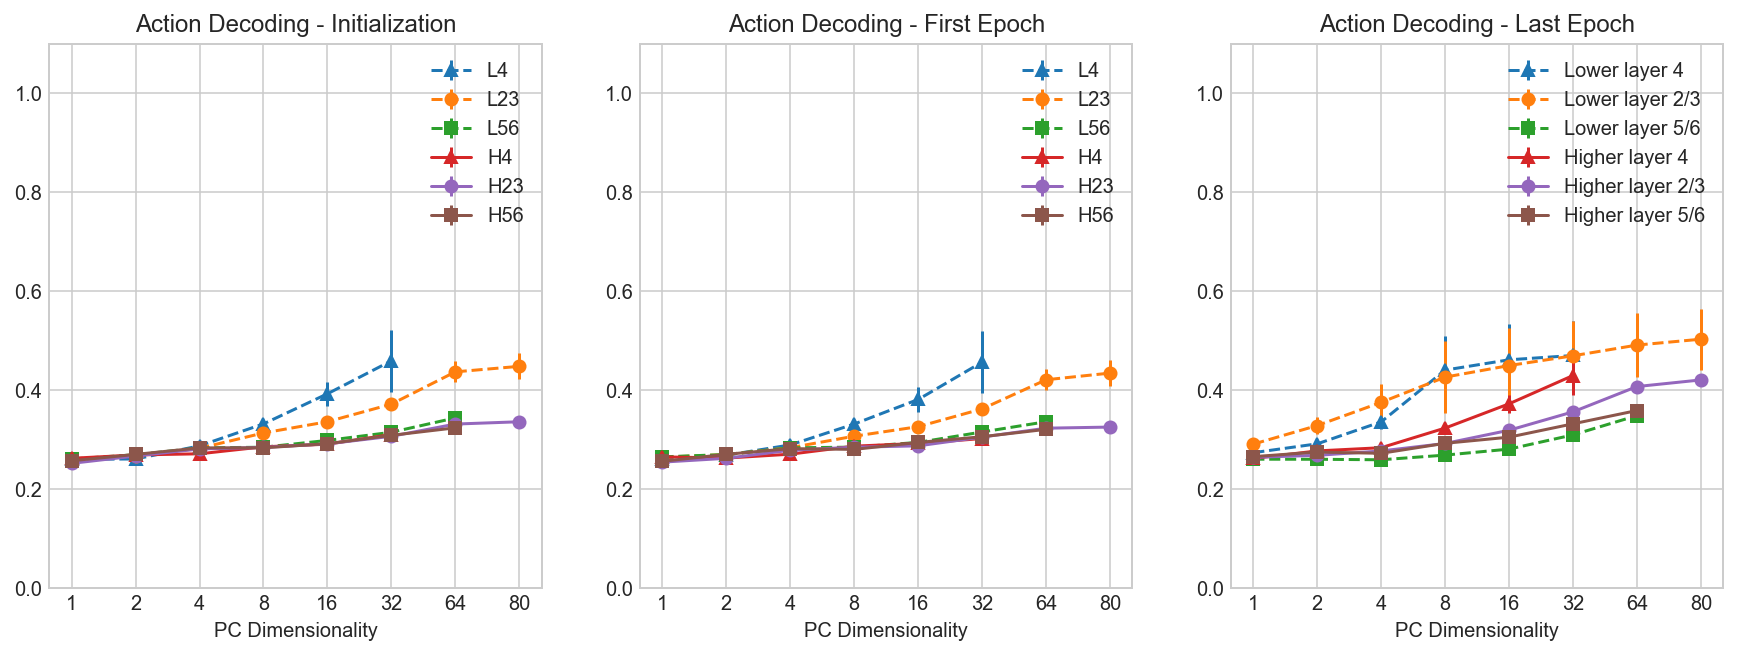

In [130]:
ffact = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Action Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4actPC[:,0],yerr=std_accs_L4actPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23actPC[:,0],yerr=std_accs_L23actPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56actPC[:,0],yerr=std_accs_L56actPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4actPC[:,0],yerr=std_accs_H4actPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23actPC[:,0],yerr=std_accs_H23actPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56actPC[:,0],yerr=std_accs_H56actPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(132)
plt.title('Action Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4actPC[:,1],yerr=std_accs_L4actPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23actPC[:,1],yerr=std_accs_L23actPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56actPC[:,1],yerr=std_accs_L56actPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4actPC[:,1],yerr=std_accs_H4actPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23actPC[:,1],yerr=std_accs_H23actPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56actPC[:,1],yerr=std_accs_H56actPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(133)
plt.title('Action Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4actPC[:,-1],yerr=std_accs_L4actPC[:,-1],label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23actPC[:,-1],yerr=std_accs_L23actPC[:,-1],label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56actPC[:,-1],yerr=std_accs_L56actPC[:,-1],label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4actPC[:,-1],yerr=std_accs_H4actPC[:,-1],label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23actPC[:,-1],yerr=std_accs_H23actPC[:,-1],label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56actPC[:,-1],yerr=std_accs_H56actPC[:,-1],label='Higher layer 5/6',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1,1))

Text(0, 0.5, 'Accuracy')

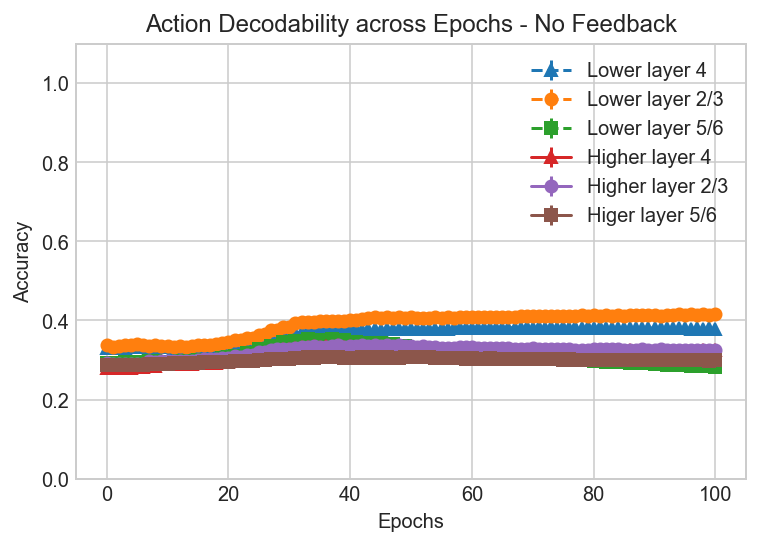

In [131]:
fact_pcs = plt.figure()
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L4actPC,0),yerr=np.var(mean_accs_L4actPC,0),label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L23actPC,0),yerr=np.var(mean_accs_L23actPC,0),label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_L56actPC,0),yerr=np.var(mean_accs_L56actPC,0),label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H4actPC,0),yerr=np.var(mean_accs_H4actPC,0),label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H23actPC,0),yerr=np.var(mean_accs_H23actPC,0),label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(n_epochs+1),np.mean(mean_accs_H56actPC,0),yerr=np.var(mean_accs_H56actPC,0),label='Higer layer 5/6',fmt='-s')
plt.xlabel('Epochs')
plt.ylim(0,1.1)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Action Decodability across Epochs - No Feedback')
plt.ylabel('Accuracy')

#### Temporal accuracies

In [132]:
labelsTrain = {}
labelsTest = {}
labelsTestTemp = {}

In [133]:
for cntr in range(nRuns):
#     labelsTrain[cntr] = np.argmax(yRepsTrain[cntr]@template[cntr].T,-1)
    labelsTest[cntr] = np.argmax(yRepsTest[cntr]@template[cntr].T,-1)
    labelsTestTemp[cntr] = np.argmax(yRepsTestTemp[cntr]@template[cntr].T,-1)

In [134]:
# preds_train = {}
preds_test = {}
preds_temp = {}

# accs_train = np.zeros((nRuns,n_epochs+1))
accs_test = np.zeros((nRuns,n_epochs+1))
accs_temp = np.zeros((nRuns,n_epochs+1))

for cntr in range(nRuns):
#     preds_train[cntr] = np.argmax(np.abs(np.round_(out_train[cntr]))@template[cntr].T,-1)
    preds_test[cntr] = np.argmax(np.abs(np.round_(out_test[cntr]))@template[cntr].T,-1)
    preds_temp[cntr] = np.argmax(np.abs(np.round_(out_temp[cntr]))@template[cntr].T,-1)
    
    for ep in range(n_epochs+1): 
#         accs_train[cntr,ep] = accuracy_score(labelsTrain[cntr].ravel(),preds_train[cntr][ep].ravel())
        accs_test[cntr,ep] = accuracy_score(labelsTest[cntr].ravel(),preds_test[cntr][ep].ravel())
        accs_temp[cntr,ep] = accuracy_score(labelsTestTemp[cntr].ravel(),preds_temp[cntr][ep].ravel())

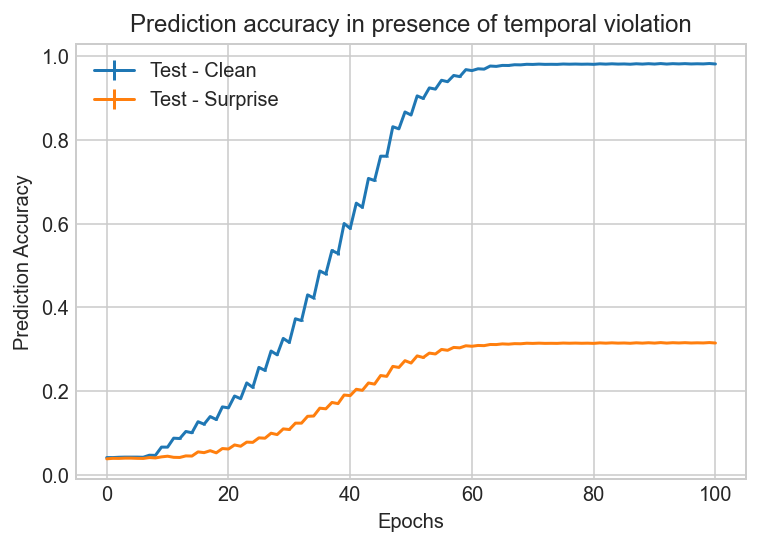

In [135]:
# plt.errorbar(np.arange(n_epochs+1),np.mean(accs_train,0),yerr=np.var(accs_train,0),fmt='-',label='Train')
plt.errorbar(np.arange(n_epochs+1),np.mean(accs_test,0),yerr=np.var(accs_test,0),fmt='-',label='Test - Clean')
plt.errorbar(np.arange(n_epochs+1),np.mean(accs_temp,0),yerr=np.var(accs_temp,0),fmt='-',label='Test - Surprise')
plt.xlabel('Epochs')
plt.ylabel('Prediction Accuracy')
plt.legend()
plt.title('Prediction accuracy in presence of temporal violation')
plt.show()

In [136]:
np.save(pp+'no-fb-no-violations-accs-lattice',accs_test)
np.save(pp+'no-fb-temporal-violations-accs-lattice',accs_temp)

### Spatial violations

In [137]:
from numpy.random import normal

In [138]:
noise_stds = np.linspace(0,1,6)

In [139]:
repsTrainNoisy = {}
repsTestNoisy = {}

In [140]:
for cntr in range(nRuns):
    for nn, noise in enumerate(noise_stds):
        repsTrainNoisy[cntr,nn] = repsTrain[cntr] + normal(0,noise,repsTrain[cntr].shape)
        repsTestNoisy[cntr,nn] = repsTest[cntr] + normal(0,noise,repsTest[cntr].shape)

In [141]:
noisy_train_loaders = {}
noisy_test_loaders = {}

In [142]:
for cntr in range(nRuns):
    for nn, noise in enumerate(noise_stds):
        noisy_train_loaders[cntr,nn] = makeTensorLoaders((repsTrainNoisy[cntr,nn],yRepsTrain[cntr],
                                                            eTrain[cntr],surpTrain[cntr]),batch_size,shuffle=False)
        noisy_test_loaders[cntr,nn] = makeTensorLoaders((repsTestNoisy[cntr,nn],yRepsTest[cntr],
                                                            eTest[cntr],surpTest[cntr]),batch_size,shuffle=False)

In [143]:
nNoise = len(noise_stds)

In [144]:
def pass_data_store_activations_noisy(loader, nData, 
                                nRuns=nRuns, nNoise=nNoise, n_epochs=n_epochs, nSteps=nSteps, pop_list=pop_list, n_latent=n_latent,
                                batch_size = batch_size):
    
    model = {}
    
    activations_hidden_L23_np = {}
    activations_hidden_L4_np = {}
    activations_hidden_L56_np = {}

    activations_hidden_H23_np = {}
    activations_hidden_H4_np = {}
    activations_hidden_H56_np = {}

    activations_out_np = {}
    
    for cntr in range(nRuns):
        for nn in range(nNoise):
            activations_hidden_L23_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,pop_list[1]*n_latent))
            activations_hidden_L4_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,pop_list[0]*n_latent))
            activations_hidden_L56_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,pop_list[2]*n_latent))

            activations_hidden_H23_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,pop_list[1]*n_latent))
            activations_hidden_H4_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,pop_list[0]*n_latent))
            activations_hidden_H56_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,pop_list[2]*n_latent))

            activations_out_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,dim))
        
            for e in tqdm(range(n_epochs+1)):

                cnt = 0

                ## Load model
                model[cntr] = microcircuit(n_features=dim,hidden_dim=n_latent,bsize=batch_size,manual_seed=seeds[cntr],task='lattice')
                model[cntr].to(device)
                model[cntr].load_state_dict(torch.load(pp_pts[cntr]+'predRNN_epoch_'+str(e)+'.pt'))
                model[cntr].eval()

                ## Pass clean samples
                for data, f_target, lastEvent, surpriseBinary in loader[cntr,nn]:

                    if train_on_gpu:
                        data, f_targetC = data.float().cuda(), f_target.float().cuda()
                    else: data, f_targetC = data.float(), f_target.float()

                    target = f_target

                    output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[cntr](data)

                    ## Collect activations  
                    act_hidden_L23 = np.squeeze(RNN_outputs[0].detach().cpu().numpy())
                    act_hidden_L4 = np.squeeze(RNN_outputs[1].detach().cpu().numpy())
                    act_hidden_L56 = np.squeeze(RNN_outputs[2].detach().cpu().numpy())

                    act_hidden_H23 = np.squeeze(RNN_outputs[3].detach().cpu().numpy())
                    act_hidden_H4 = np.squeeze(RNN_outputs[4].detach().cpu().numpy())
                    act_hidden_H56 = np.squeeze(RNN_outputs[5].detach().cpu().numpy())

                    output_pred = np.squeeze(output_pred.detach().cpu().numpy())

                    for i in range(batch_size):
                        if i < len(data):
                            label = target.data[i]

                            activations_hidden_L23_np[cntr,nn][e,cnt] = act_hidden_L23[i]
                            activations_hidden_L4_np[cntr,nn][e,cnt] = act_hidden_L4[i]
                            activations_hidden_L56_np[cntr,nn][e,cnt] = act_hidden_L56[i]

                            activations_hidden_H23_np[cntr,nn][e,cnt] = act_hidden_H23[i]
                            activations_hidden_H4_np[cntr,nn][e,cnt] = act_hidden_H4[i]
                            activations_hidden_H56_np[cntr,nn][e,cnt] = act_hidden_H56[i]

                            activations_out_np[cntr,nn][e,cnt] = output_pred[i]

                            cnt += 1

    return (activations_hidden_L23_np,activations_hidden_L4_np,activations_hidden_L56_np,
            activations_hidden_H23_np,activations_hidden_H4_np,activations_hidden_H56_np), activations_out_np

In [145]:
# L23_train_noisy = {}
# L4_train_noisy = {}
# L56_train_noisy = {}

# H23_train_noisy = {}
# H4_train_noisy = {}
# H56_train_noisy = {}

# out_train_noisy = {}

In [146]:
L23_test_noisy = {}
L4_test_noisy = {}
L56_test_noisy = {}

H23_test_noisy = {}
H4_test_noisy = {}
H56_test_noisy = {}

out_test_noisy = {}

In [147]:
# (L23_train_noisy,L4_train_noisy,L56_train_noisy,
#  H23_train_noisy,H4_train_noisy,H56_train_noisy), out_train_noisy = pass_data_store_activations_noisy(noisy_train_loaders,nTrain)

(L23_test_noisy,L4_test_noisy,L56_test_noisy,
 H23_test_noisy,H4_test_noisy,H56_test_noisy), out_test_noisy = pass_data_store_activations_noisy(noisy_test_loaders,nTest)

100%|██████████| 101/101 [00:07<00:00, 13.57it/s]


In [148]:
predsN_train = {}
accsN_train = np.zeros((nRuns,len(noise_stds),n_epochs+1))

predsN_test = {}
accsN_test = np.zeros((nRuns,len(noise_stds),n_epochs+1))

In [149]:
for cntr in range(nRuns):
    for nn, noise in enumerate(noise_stds):
        predsN_test[cntr,nn] = np.argmax(out_test_noisy[cntr,nn]@template[cntr].T,-1)
        accsN_test[cntr,nn] = np.sum(np.sum(((labelsTest[cntr] - predsN_test[cntr,nn])==0)*1,-1),-1)/(nTest*6)

In [150]:
name = "Dark2_r"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

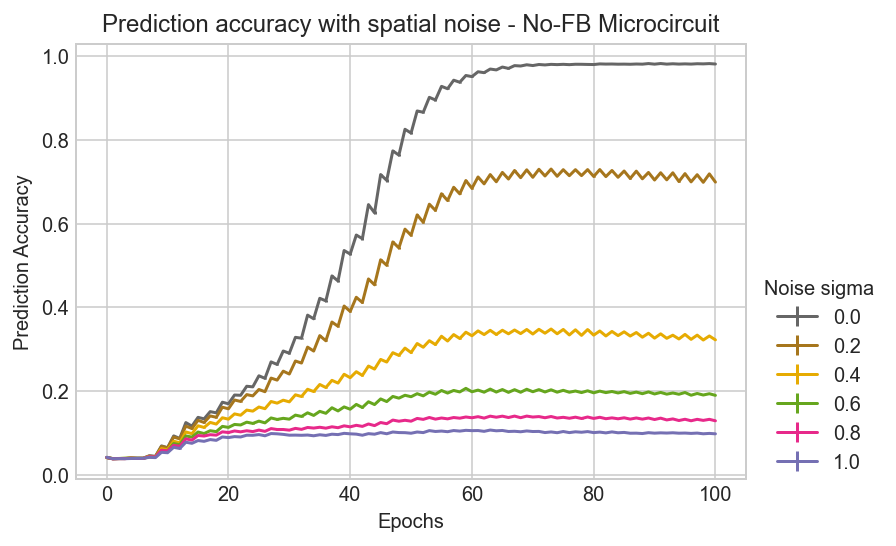

In [151]:
fpredspat = plt.figure()
for nn, noise in enumerate(noise_stds):
    plt.errorbar(np.arange(n_epochs+1),np.mean(accsN_test[:,nn],0),yerr=np.var(accsN_test[:,nn],0),
                 fmt='-',label=np.round(noise,2),
                 c=colors[nn])
plt.xlabel('Epochs')
plt.ylabel('Prediction Accuracy')
plt.legend(title="Noise sigma",bbox_to_anchor=(1,0.5))
plt.title('Prediction accuracy with spatial noise - No-FB Microcircuit')
plt.show()

In [152]:
np.save(pp+'no-fb-spatial-noisy-accs-lattice',accsN_test)

#### Dimensionality (linear)

In [153]:
def rnnLinDim(acts):
    nEpochs,nSeqs, nRolls, nNeurons = acts.shape
    nSamps = nSeqs*nRolls
    
    eig_mat = np.zeros((nEpochs,nNeurons))
        
    for ep in tqdm(range(nEpochs)):
        reps = acts[ep]
        
        ## reshape
        actsR = np.zeros((nSeqs*nRolls,nNeurons))
        cnt = 0
        
        for ii in range(nSeqs):
            for jj in range(nRolls):
                
                actsR[cnt] = reps[ii,jj]
                cnt += 1
        
        scaler = StandardScaler()
        actsScaled = scaler.fit_transform(actsR)
        cov = actsScaled.T@actsScaled
        eig_mat[ep] = eigvals(cov)
        num = np.sum(eig_mat,1)**2
        den = np.sum(eig_mat**2,1) + 1e-17
        PR = num/den
    return PR

In [154]:
L23LinDim = np.zeros((nRuns,n_epochs+1))
L4LinDim = np.zeros((nRuns,n_epochs+1))
L56LinDim = np.zeros((nRuns,n_epochs+1))

H23LinDim = np.zeros((nRuns,n_epochs+1))
H4LinDim = np.zeros((nRuns,n_epochs+1))
H56LinDim = np.zeros((nRuns,n_epochs+1))

In [155]:
for cntr in range(nRuns):
    L23LinDim[cntr] = rnnLinDim(L23_test[cntr])
    L4LinDim[cntr] = rnnLinDim(L4_test[cntr])
    L56LinDim[cntr] = rnnLinDim(L56_test[cntr])

    H23LinDim[cntr] = rnnLinDim(H23_test[cntr])
    H4LinDim[cntr] = rnnLinDim(H4_test[cntr])
    H56LinDim[cntr] = rnnLinDim(H56_test[cntr])

100%|██████████| 101/101 [00:00<00:00, 279.75it/s]


#### Dimensionality (non-linear)

In [156]:
def rnnNonLinDim(acts,nTypes=2,subsample=True,ds=100):
    
    nEpochs,nSeqs, nRolls, nNeurons = acts.shape
    nSamps = nSeqs*nRolls
    
    dims_mat = np.zeros((nEpochs,nTypes))
        
    for ep in (range(nEpochs)):
        reps = acts[ep]
        
        ## reshape
        actsR = np.zeros((nSeqs*nRolls,nNeurons))
        cnt = 0
        
        for ii in range(nSeqs):
            for jj in range(nRolls):
                
                actsR[cnt] = reps[ii,jj]
                cnt += 1
        
        scaler = StandardScaler()
        actsScaled = scaler.fit_transform(actsR)
        
        if subsample:
            actsScaled = actsScaled[::ds]
        
        dims_mat[ep,0] = MiND_ML().fit(actsScaled).dimension_
#         print(dims_mat[ep,0])
        dims_mat[ep,1] = CorrInt().fit(actsScaled).dimension_
#         print(dims_mat[ep,1])
#         dims_mat[ep,2] = MLE().fit(actsScaled).dimension_
#         print(dims_mat[ep,2])
#         dims_mat[ep,3] = DANCo().fit(actsScaled).dimension_
        
    return np.mean(dims_mat,-1),dims_mat

In [157]:
L23NonLinDim = np.zeros((nRuns,n_epochs+1))
L4NonLinDim = np.zeros((nRuns,n_epochs+1))
L56NonLinDim = np.zeros((nRuns,n_epochs+1))

H23NonLinDim = np.zeros((nRuns,n_epochs+1))
H4NonLinDim = np.zeros((nRuns,n_epochs+1))
H56NonLinDim = np.zeros((nRuns,n_epochs+1))

In [158]:
L23_ND_mat = {}
L4_ND_mat = {}
L56_ND_mat = {}
H23_ND_mat = {}
H4_ND_mat = {}
H56_ND_mat = {}

In [159]:
for cntr in tqdm(range(nRuns)):
    L23NonLinDim[cntr], L23_ND_mat[cntr] = rnnNonLinDim(L23_test[cntr])
    L4NonLinDim[cntr], L4_ND_mat[cntr] = rnnNonLinDim(L4_test[cntr])
    L56NonLinDim[cntr], L56_ND_mat[cntr] = rnnNonLinDim(L56_test[cntr])

    H23NonLinDim[cntr], H23_ND_mat[cntr] = rnnNonLinDim(H23_test[cntr])
    H4NonLinDim[cntr], H4_ND_mat[cntr] = rnnNonLinDim(H4_test[cntr])
    H56NonLinDim[cntr], H56_ND_mat[cntr] = rnnNonLinDim(H56_test[cntr])

100%|██████████| 5/5 [01:58<00:00, 23.74s/it]


In [160]:
L23_NonLineDim_mean = np.mean(L23NonLinDim,0)
L4_NonLineDim_mean = np.mean(L4NonLinDim,0)
L56_NonLineDim_mean = np.mean(L56NonLinDim,0)

H23_NonLineDim_mean = np.mean(H23NonLinDim,0)
H4_NonLineDim_mean = np.mean(H4NonLinDim,0)
H56_NonLineDim_mean = np.mean(H56NonLinDim,0)

L23_NonLineDim_std = np.var(L23NonLinDim,0)
L4_NonLineDim_std = np.var(L4NonLinDim,0)
L56_NonLineDim_std = np.var(L56NonLinDim,0)

H23_NonLineDim_std = np.var(H23NonLinDim,0)
H4_NonLineDim_std = np.var(H4NonLinDim,0)
H56_NonLineDim_std = np.var(H56NonLinDim,0)

In [161]:
L23_dim = np.zeros((nRuns,n_epochs+1))
L4_dim = np.zeros((nRuns,n_epochs+1))
L56_dim = np.zeros((nRuns,n_epochs+1))

H23_dim = np.zeros((nRuns,n_epochs+1))
H4_dim = np.zeros((nRuns,n_epochs+1))
H56_dim = np.zeros((nRuns,n_epochs+1))

In [162]:
for cntr in range(nRuns):
    L23_dim[cntr] = L23LinDim[cntr]/L23NonLinDim[cntr]
    L4_dim[cntr] = L4LinDim[cntr]/L4NonLinDim[cntr]
    L56_dim[cntr] = L56LinDim[cntr]/L56NonLinDim[cntr]
    H23_dim[cntr] = H23LinDim[cntr]/H23NonLinDim[cntr]
    H4_dim[cntr] = H4LinDim[cntr]/H4NonLinDim[cntr]
    H56_dim[cntr] = H56LinDim[cntr]/H56NonLinDim[cntr]

In [163]:
np.save(pp+'L23DG_no-fb_lattice',L23_dim)
np.save(pp+'L4DG_no-fb_lattice',L4_dim)
np.save(pp+'L56DG_no-fb_lattice',L56_dim)
np.save(pp+'H23DG_no-fb_lattice',H23_dim)
np.save(pp+'H4DG_no-fb_lattice',H4_dim)
np.save(pp+'H56DG_no-fb_lattice',H56_dim)

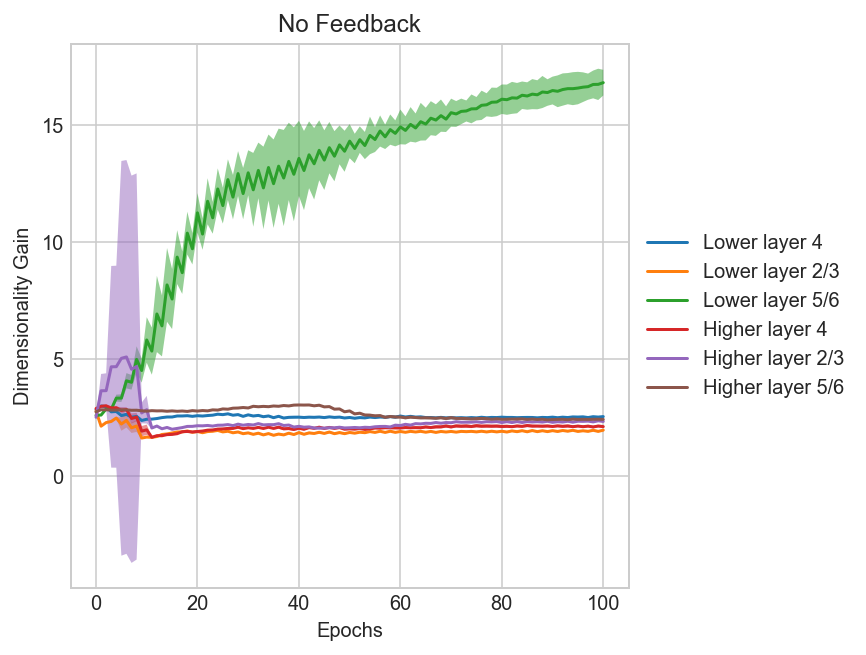

In [164]:
ffTotDim = plt.figure(figsize=(5,5))

plt.subplot(111)

plt.plot(np.arange(n_epochs+1),np.mean(L4_dim,0),label='Lower layer 4')
plt.fill_between(np.arange(n_epochs+1),np.mean(L4_dim,0)-np.var(L4_dim,0),np.mean(L4_dim,0)+np.var(L4_dim,0),alpha=0.5)
plt.plot(np.arange(n_epochs+1),np.mean(L23_dim,0),label='Lower layer 2/3')
plt.fill_between(np.arange(n_epochs+1),np.mean(L23_dim,0)-np.var(L23_dim,0),np.mean(L23_dim,0)+np.var(L23_dim,0),alpha=0.5)
plt.plot(np.arange(n_epochs+1),np.mean(L56_dim,0),label='Lower layer 5/6')
plt.fill_between(np.arange(n_epochs+1),np.mean(L56_dim,0)-np.var(L56_dim,0),np.mean(L56_dim,0)+np.var(L56_dim,0),alpha=0.5)

plt.plot(np.arange(n_epochs+1),np.mean(H4_dim,0),label='Higher layer 4')
plt.fill_between(np.arange(n_epochs+1),np.mean(H4_dim,0)-np.var(H4_dim,0),np.mean(H4_dim,0)+np.var(H4_dim,0),alpha=0.5)
plt.plot(np.arange(n_epochs+1),np.mean(H23_dim,0),label='Higher layer 2/3')
plt.fill_between(np.arange(n_epochs+1),np.mean(H23_dim,0)-np.var(H23_dim,0),np.mean(H23_dim,0)+np.var(H23_dim,0),alpha=0.5)
plt.plot(np.arange(n_epochs+1),np.mean(H56_dim,0),label='Higher layer 5/6')
plt.fill_between(np.arange(n_epochs+1),np.mean(H56_dim,0)-np.var(H56_dim,0),np.mean(H56_dim,0)+np.var(H56_dim,0),alpha=0.5)

plt.xlabel('Epochs')
plt.ylabel('Dimensionality Gain')
# plt.ylim(0.9,2.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('No Feedback')
plt.show()

In [165]:
ffTotDim.savefig('Dimensionality-gain-no-fb-across-learning-lattice.png',dpi=300,bbox_inches='tight')
ffTotDim.savefig('Dimensionality-gain-no-fb-across-learning-lattice.svg',dpi=300,bbox_inches='tight')